In [78]:
# ── Cell: Environment setup ─────────────────────────────────────────────────────────

import os, gc, random, warnings, pathlib
import numpy as np, pandas as pd
from tqdm.auto import tqdm
import scipy.io as sio

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             log_loss)
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import shap, matplotlib.pyplot as plt, seaborn as sns

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Device:", device)

Device: mps


In [79]:
# ── Cell: Load data ─────────────────────────────────────────────────────────

mat = sio.loadmat("OR_data.mat", squeeze_me=True, struct_as_record=False)["OR_data"]
print("Surgeries:", len(mat))

PHYS   = [str(f) for f in mat[0].phys_ind_order]          # 15
DERIV  = [f"d_{f}" for f in PHYS]                         # 15
DRUG   = [str(c) for c in mat[0].W_5sec.DrugInfo.drugClass]  # 9 drug classes
TS     = [f"ts_{d}" for d in DRUG]                        # 9
CD     = [f"cd_{d}" for d in DRUG]                        # 9
COLS   = PHYS + DERIV + TS + CD                           # 48

dfs = []
for s in mat:
    ms = s.W_5sec
    X_phys = ms.multiS_noDrug.X_norm_noNan                # (N,30)
    ts  = np.nan_to_num(ms.DrugInfo.timeSince)
    cum = np.nan_to_num(ms.DrugInfo.cumulDose)
    X   = np.hstack([X_phys, ts, cum])                    # (N,48)
    y   = ms.multiS_noDrug.noc_stim.reshape(-1,1)
    df  = pd.DataFrame(np.hstack([X,y]), columns=COLS+["label"])
    dfs.append(df.astype(np.float32))
print("Columns OK:", COLS[:10])


Surgeries: 101
Columns OK: ['MuHR', 'SigmaHR', 'TotalPower', 'HF', 'LFnu', 'HFnu', 'LFnu_noVLF', 'LF/HF', 'TonicEDA', 'MuAmp']


In [80]:
# ── Cell: Preprocess data ───────────────────────────────────────────────────

X_all = np.vstack([d[COLS].values for d in dfs])
scaler = StandardScaler().fit(X_all)
X_all = scaler.transform(X_all).astype(np.float32)
y_all = np.hstack([d.label.values for d in dfs]).astype(np.float32)

lens   = [len(d) for d in dfs]
cumidx = np.cumsum([0]+lens)
def idx_ranges(sid): return np.arange(cumidx[sid], cumidx[sid+1])

class WinDS(Dataset):
    def __init__(s,X,y): s.X=torch.from_numpy(X); s.y=torch.from_numpy(y)
    def __len__(s): return len(s.X)
    def __getitem__(s,i): return s.X[i], s.y[i]
full_ds = WinDS(X_all, y_all)


In [81]:
from sklearn.linear_model import LogisticRegression

def fit_logreg_AIC_grid(Xtr, ytr, Cs=np.logspace(-3,2,40)):
    best_aic, best, bestC = np.inf, None, None
    for C in Cs:
        clf = LogisticRegression(penalty="l1", C=C, solver="saga",
                                 class_weight="balanced", max_iter=400,
                                 random_state=SEED, n_jobs=-1)
        clf.fit(Xtr, ytr)
        if np.count_nonzero(clf.coef_)==0: continue
        p = clf.predict_proba(Xtr)[:,1]
        dev = 2*log_loss(ytr, p, normalize=False)
        df  = np.count_nonzero(clf.coef_)+1
        aic = dev + 2*df
        if aic < best_aic: best_aic, best, bestC = aic, clf, C
    return best, bestC


In [82]:
# ── Cell: Define logistic regression with LOSO evaluation ──────────────────────

def run_logreg_LOSO(with_drug=True):
    idx = np.arange(48) if with_drug else np.arange(30)
    tag = "LogReg_L1AIC_drug" if with_drug else "LogReg_L1AIC_nodrug"
    rec=[]
    for sid in tqdm(range(len(dfs)), desc=tag):
        test  = idx_ranges(sid)
        train = np.setdiff1d(np.arange(len(full_ds)), test)
        clf,_ = fit_logreg_AIC_grid(X_all[train][:,idx], y_all[train])
        p     = clf.predict_proba(X_all[test][:,idx])[:,1]
        auroc = roc_auc_score(y_all[test], p) if len(np.unique(y_all[test]))>1 else np.nan
        rec.append(dict(sid=sid, model=tag,
                        auroc=auroc,
                        auprc=average_precision_score(y_all[test], p),
                        prev=y_all[test].mean()))
    return pd.DataFrame(rec)

In [22]:
# ── Cell: LogReg + drug accuracy summary with 95 % CI ──────────────────────

from scipy.stats import bootstrap

# make sure df_logreg_drug exists; if not, run the baseline cell first
try:
    df = df_logreg_drug.copy()
except NameError:
    df = run_logreg_LOSO(with_drug=True)   # fall‑back: compute on the fly

# helper: bootstrap CI for the median
def median_ci(values, n_resamples=10_000, seed=SEED):
    res = bootstrap((values,), np.median, confidence_level=0.95,
                    n_resamples=n_resamples, random_state=seed, method='basic')
    median = np.median(values)
    lo, hi = res.confidence_interval.low, res.confidence_interval.high
    return f"{median:.3f}  ({lo:.3f} – {hi:.3f})"

auroc_ci = median_ci(df.auroc.values)
auprc_ci = median_ci(df.auprc.values)

summary = pd.DataFrame({
    "Model": ["LogReg_L1AIC_drug"],
    "AUROC (95 % CI)": [auroc_ci],
    "AUPRC (95 % CI)": [auprc_ci],
    "Median prevalence": [df.prev.median().round(3)]
}).set_index("Model")

display(summary)


,AUROC (95 % CI),AUPRC (95 % CI),Median prevalence
Model,,,
LogReg_L1AIC_drug,0.623 (0.583 – 0.643),0.291 (0.265 – 0.317),0.225


In [24]:
# -- Cell: Sanity check on data ──────────────────────────────────────────────

print(len(COLS))           # 48
print(COLS[30:35])         # ['ts_Sedative', 'ts_Antinoc', ...] begins drug block
print(COLS[45:48])         # ['cd_Hydralazine', 'cd_Sevo', 'label' is separate]


48
['ts_Sedative', 'ts_Antinoc', 'ts_MuscleRelaxant', 'ts_Pressor', 'ts_BetaBlocker']
['cd_NMDA-Ant', 'cd_Hydralazine', 'cd_Sevo']


In [25]:
# ── Cell: LogReg (no‑drug) accuracy summary with 95 % CI ─────────────────────────

# 1) Make sure the DataFrame exists; otherwise compute it on the fly
try:
    df = df_logreg_nodrug.copy()
except NameError:
    df = run_logreg_LOSO(with_drug=False)   # builds it if missing

# 2) Helper to get bootstrap CI for the median
def median_ci(arr, n_resamples=10_000, seed=SEED):
    res = bootstrap((arr,), np.median, confidence_level=0.95,
                    n_resamples=n_resamples, random_state=seed, method="basic")
    med = np.median(arr)
    lo, hi = res.confidence_interval
    return f"{med:.3f}  ({lo:.3f} – {hi:.3f})"

auroc_ci = median_ci(df.auroc.values)
auprc_ci = median_ci(df.auprc.values)

# 3) Display tidy summary table
summary_nd = pd.DataFrame({
    "Model": ["LogReg_L1AIC_nodrug"],
    "AUROC (95 % CI)": [auroc_ci],
    "AUPRC (95 % CI)": [auprc_ci],
    "Median prevalence": [df.prev.median().round(3)]
}).set_index("Model")

display(summary_nd)


,AUROC (95 % CI),AUPRC (95 % CI),Median prevalence
Model,,,
LogReg_L1AIC_nodrug,0.624 (0.602 – 0.649),0.291 (0.266 – 0.324),0.225


In [27]:
# ── Cell: Random‑Forest baselines (+drug / -drug) with 95 % CI ───────────

from sklearn.ensemble import RandomForestClassifier
def run_rf_LOSO(with_drug=True):
    idx = np.arange(48) if with_drug else np.arange(30)
    tag = "RF_Bag_drug" if with_drug else "RF_Bag_nodrug"
    rec=[]
    for sid in tqdm(range(len(dfs)), desc=tag):
        test  = idx_ranges(sid)
        train = np.setdiff1d(np.arange(len(full_ds)), test)
        rf = RandomForestClassifier(
                n_estimators=200, max_depth=6, max_features=None,
                bootstrap=True, max_samples=0.9,
                class_weight='balanced_subsample',
                random_state=SEED, n_jobs=-1)
        rf.fit(X_all[train][:,idx], y_all[train])
        p = rf.predict_proba(X_all[test][:,idx])[:,1]
        auroc = roc_auc_score(y_all[test], p) if len(np.unique(y_all[test]))>1 else np.nan
        rec.append(dict(sid=sid, model=tag,
                        auroc=auroc,
                        auprc=average_precision_score(y_all[test], p),
                        prev=y_all[test].mean()))
    return pd.DataFrame(rec)

df_rf_drug   = run_rf_LOSO(True)
df_rf_nodrug = run_rf_LOSO(False)

# ── Display Random‑Forest baselines (+drug / -drug) with 95 % CI ───────────

# --------------------------------------------------------------------------
# 1) Ensure the two DataFrames exist; recompute if the earlier cell wasn't run
def ensure_rf_df(with_drug):
    tag = "df_rf_drug" if with_drug else "df_rf_nodrug"
    try:
        return globals()[tag].copy()
    except KeyError:
        return run_rf_LOSO(with_drug=with_drug)

df_rf_drug   = ensure_rf_df(True)
df_rf_nodrug = ensure_rf_df(False)

# Quick peek at first few rows for each
print("Random‑Forest  WITH drugs:");  display(df_rf_drug.head())
print("Random‑Forest WITHOUT:");      display(df_rf_nodrug.head())

# --------------------------------------------------------------------------
# 2) Helper for bootstrap CI on the median
def median_ci(arr, n=10_000, seed=SEED):
    res = bootstrap((arr,), np.median, confidence_level=0.95,
                    n_resamples=n, random_state=seed, method="basic")
    med = np.median(arr)
    lo, hi = res.confidence_interval
    return f"{med:.3f}  ({lo:.3f} – {hi:.3f})"

def summarize(df, label):
    return dict(
        Model = label,
        AUROC = median_ci(df.auroc.values),
        AUPRC = median_ci(df.auprc.values),
        Prev  = f"{df.prev.median():.3f}"
    )

summary = pd.DataFrame([
    summarize(df_rf_drug,   "RF_Bag_drug"),
    summarize(df_rf_nodrug, "RF_Bag_nodrug")
]).set_index("Model")

print("\n── Random‑Forest overall performance ──")
display(summary)


RF_Bag_drug:   0%|          | 0/101 [00:00<?, ?it/s]

RF_Bag_nodrug:   0%|          | 0/101 [00:00<?, ?it/s]

Random‑Forest  WITH drugs:


,sid,model,auroc,auprc,prev
0,0,RF_Bag_drug,0.850307,0.470253,0.138230
1,1,RF_Bag_drug,0.816835,0.549663,0.225312
2,2,RF_Bag_drug,0.823682,0.393618,0.164924
3,3,RF_Bag_drug,0.736767,0.447408,0.242995
4,4,RF_Bag_drug,0.815922,0.512499,0.213533


Random‑Forest WITHOUT:


,sid,model,auroc,auprc,prev
0,0,RF_Bag_nodrug,0.619380,0.194109,0.138230
1,1,RF_Bag_nodrug,0.548594,0.243847,0.225312
2,2,RF_Bag_nodrug,0.558212,0.200019,0.164924
3,3,RF_Bag_nodrug,0.645533,0.388834,0.242995
4,4,RF_Bag_nodrug,0.673995,0.339240,0.213533



── Random‑Forest overall performance ──


,AUROC,AUPRC,Prev
Model,,,
RF_Bag_drug,0.716 (0.699 – 0.759),0.399 (0.370 – 0.434),0.225
RF_Bag_nodrug,0.662 (0.640 – 0.700),0.339 (0.309 – 0.364),0.225


In [83]:
# ── Cell: TCN + train / infer helpers ───────────────────────────────────────

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

class TCN(nn.Module):
    """
    1‑D convolution across the *dummy time axis* (length 1).
    Each feature is treated as a channel, so we keep shape (B, F, 1).
    """
    def __init__(self, n_feat, k=6, h=64):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=n_feat, out_channels=h,
                              kernel_size=k, padding=k-1)
        self.bn   = nn.BatchNorm1d(h)
        self.head = nn.Sequential(
            nn.Linear(h, 32), nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, 1)
        )
    def forward(self, x):          # x: (B, F)
        x = x.unsqueeze(-1)        # -> (B, F, 1)  ✅ keep F as channels
        x = F.relu(self.bn(self.conv(x)))
        x = torch.max_pool1d(x, x.shape[-1]).squeeze(-1)
        return self.head(x).squeeze(-1)

def train_epoch(model, loader, loss_fn, opt):
    model.train(); tot=0; n=0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(); out = model(xb)
        loss = loss_fn(out, yb); loss.backward(); opt.step()
        tot += loss.item()*len(xb); n += len(xb)
    return tot/n

@torch.no_grad()
def infer(model, loader):
    model.eval(); P=[]; Y=[]
    for xb, yb in loader:
        P.append(torch.sigmoid(model(xb.to(device))).cpu())
        Y.append(yb)
    return torch.cat(P).numpy(), torch.cat(Y).numpy()

In [84]:
# ── Cell: Run multiple TL variants ───────────────────────────────────────

def run_TL_multiple(adapt_minutes, with_drug=True,
                    base_epochs=12, ft_epochs=3, batch=128):
    """
    adapt_minutes : list like [1,3,6,10]
    with_drug     : True → 48 features, False → 30 features
    returns       : DataFrame with one row per surgery per adaptation length
    """
    feat_idx = np.arange(48) if with_drug else np.arange(30)
    suffix   = "drug" if with_drug else "nodrug"
    records  = []

    outer = tqdm(adapt_minutes, desc=f"TL grid ({suffix})")
    for minutes in outer:
        wins = int(minutes * 12)           # 12 *5‑s windows per minute
        tag  = f"TL_{minutes}min_{suffix}"

        inner = tqdm(range(len(dfs)), desc=tag, leave=False)
        for sid in inner:
            test_idx   = idx_ranges(sid)
            adapt_idx  = test_idx[:wins]
            eval_idx   = test_idx[wins:]s
            train_idx  = np.setdiff1d(np.arange(len(full_ds)), test_idx)

            tr_dl = DataLoader(Subset(full_ds, train_idx), batch, shuffle=True)
            ad_dl = DataLoader(Subset(full_ds, adapt_idx), batch, shuffle=True)
            ev_dl = DataLoader(Subset(full_ds, eval_idx), batch*2, shuffle=False)

            model = TCN(len(feat_idx)).to(device)
            opt   = torch.optim.Adam(model.parameters(), 1e-3)
            loss  = nn.BCEWithLogitsLoss()

            best=1e9; pat=3
            for _ in range(base_epochs):
                l = train_epoch(model, tr_dl, loss, opt)
                best, pat = (l,3) if l<best else (best, pat-1)
                if pat==0: break

            # fine‑tune head
            for p in model.parameters(): p.requires_grad_(False)
            for p in model.head.parameters(): p.requires_grad_(True)
            opt_ft = torch.optim.Adam(model.head.parameters(), 1e-4)
            for _ in range(ft_epochs):
                _ = train_epoch(model, ad_dl, loss, opt_ft)

            p, y = infer(model, ev_dl)
            auroc = roc_auc_score(y, p) if len(np.unique(y))>1 else np.nan
            auprc = average_precision_score(y, p)
            records.append(dict(sid=sid, model=tag,
                                auroc=auroc, auprc=auprc,
                                prev=y.mean()))
            del model, tr_dl, ad_dl, ev_dl; gc.collect()

    return pd.DataFrame(records)

In [33]:
# ── Cell: Run multiple TL variants (1, 3, 6, 10 minutes) ───────────────────────────────────────
adapt_list = [1, 3, 6, 10]

df_tl_drug   = run_TL_multiple(adapt_list, with_drug=True)
display(df_tl_drug.head())

TL grid (drug):   0%|          | 0/4 [00:00<?, ?it/s]

TL_1min_drug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_3min_drug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_6min_drug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_10min_drug:   0%|          | 0/101 [00:00<?, ?it/s]

,sid,model,auroc,auprc,prev
0,0,TL_1min_drug,0.775656,0.282433,0.138857
1,1,TL_1min_drug,0.662769,0.389579,0.226280
2,2,TL_1min_drug,0.726236,0.324733,0.165724
3,3,TL_1min_drug,0.714286,0.422413,0.244342
4,4,TL_1min_drug,0.691186,0.329911,0.214664


In [ ]:
# ── Cell: Run multiple TL variants (1, 3, 6, 10 minutes) ───────────────────────────────────────

df_tl_nodrug = run_TL_multiple(adapt_list, with_drug=False)
display(df_tl_nodrug.head())


In [85]:
# ── Cell: Bootstrap CI helper ───────────────────────────────────────────────

def bootstrap_ci(values, func=np.median, n_resamples=10_000, seed=SEED):
    """
    Returns (median, lo, hi) for a 95% CI on func(values) via bootstrap.
    """
    res = bootstrap((values,), func, confidence_level=0.95,
                    n_resamples=n_resamples, random_state=seed, method="basic")
    med = func(values)
    lo, hi = res.confidence_interval.low, res.confidence_interval.high
    return med, lo, hi

In [34]:
 # ── Compute and display AUROC & AUPRC with 95% CI for TL variants ────────────

# Use df_tl_drug or df_tl_nodrug as needed
df = df_tl_drug.copy()

summary_rows = []
for model_name, group in df.groupby("model"):
    med_auc, lo_auc, hi_auc = bootstrap_ci(group.auroc.values)
    med_pr,  lo_pr,  hi_pr  = bootstrap_ci(group.auprc.values)
    summary_rows.append({
        "Model":               model_name,
        "AUROC (95% CI)":      f"{med_auc:.3f} ({lo_auc:.3f}–{hi_auc:.3f})",
        "AUPRC (95% CI)":      f"{med_pr:.3f} ({lo_pr:.3f}–{hi_pr:.3f})",
        "Median prevalence":   group.prev.median().round(3)
    })

summary_df = pd.DataFrame(summary_rows).set_index("Model")
display(summary_df)


,AUROC (95% CI),AUPRC (95% CI),Median prevalence
Model,,,
TL_10min_drug,0.645 (0.616–0.659),0.327 (0.283–0.353),0.225
TL_1min_drug,0.636 (0.622–0.666),0.311 (0.281–0.339),0.226
TL_3min_drug,0.644 (0.619–0.660),0.313 (0.270–0.328),0.228
TL_6min_drug,0.642 (0.617–0.657),0.317 (0.278–0.350),0.227


In [ ]:
# ── Explanation of file directories ───────────────────────────────────────────────────────

'''
chkpt/
  global/
    base_drug.pt
    base_nodrug.pt
  fold_bases/
    base_fold0_drug.pt, … base_fold100_drug.pt
    base_fold0_nodrug.pt, … base_fold100_nodrug.pt
  tl_models/
    TL_1min_drug_sid0.pt, … TL_10min_drug_sid100.pt
    TL_1min_nodrug_sid0.pt, … TL_10min_nodrug_sid100.pt
'''

# True LOSO CV – for each patient you train a fold-specific base model on the other 100 surgeries, fine-tune its head on that patient’s first K minutes,
# save both the fold’s base and its fine-tuned TL model, evaluate AUROC/AUPRC on the rest of the patient, record results.
# Global base models – one drug-aware and one no-drug, trained on all 101 surgeries and saved for any future external validation or demo. 
# 95 % CI on median AUROC/AUPRC across the 101 folds via bootstrap.

In [37]:
# ── Cell: True LOSO CV + SAVE PER-FOLD BASE & TL MODELS ────────────────────

import gc
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample

# ── ASSUMED PREVIOUS DEFINITIONS ───────────────────────────────────────────
# TCN, train_epoch(model,loader,loss,opt), infer(model,loader) → (probs,y),
# WinDS, idx_ranges, X_all, y_all, full_ds, dfs already defined and imported
# SEED, device set above

# ── DIRECTORIES ─────────────────────────────────────────────────────────────
root = Path("chkpt")
glob_dir = root/"global";       glob_dir .mkdir(parents=True, exist_ok=True)
base_dir = root/"fold_bases";   base_dir .mkdir(parents=True, exist_ok=True)
tl_dir   = root/"tl_models";    tl_dir   .mkdir(parents=True, exist_ok=True)

# ── 1) Train & save GLOBAL BASE MODELS ──────────────────────────────────────
for with_drug, suffix in [(True,"drug"), (False,"nodrug")]:
    feat_idx = np.arange(48) if with_drug else np.arange(30)
    ckpt = glob_dir/f"base_{suffix}.pt"
    if not ckpt.exists():
        # train on ALL surgeries
        ds = WinDS(X_all[:,feat_idx], y_all)
        dl = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True)
        model = TCN(len(feat_idx)).to(device)
        opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss  = nn.BCEWithLogitsLoss()
        best,pat = 1e9,3
        for _ in range(12):
            l = train_epoch(model, dl, loss, opt)
            best,pat = (l,3) if l<best else (best,pat-1)
            if pat==0: break
        torch.save(model.state_dict(), ckpt)
        print(f"Saved global base: {ckpt.name}")

# ── 2) True LOSO CV + SAVE PER-FOLD BASE & TL MODELS ────────────────────────
adapt_list = [1,2,3,4,5,10]  # minutes
records = []

for with_drug, suffix in [(True,"drug"), (False,"nodrug")]:
    feat_idx = np.arange(48) if with_drug else np.arange(30)
    for m in adapt_list:
        wins = m * 12
        tag  = f"TL_{m}min_{suffix}"
        for sid in tqdm(range(len(dfs)), desc=tag):
            # split indices
            test_idx  = idx_ranges(sid)
            train_idx = np.setdiff1d(np.arange(len(full_ds)), test_idx)
            adapt_idx = test_idx[:wins]
            eval_idx  = test_idx[wins:]

            # 2a) train fold‐specific base on train_idx
            base = TCN(len(feat_idx)).to(device)
            ds_tr = WinDS(X_all[train_idx][:,feat_idx], y_all[train_idx])
            dl_tr = torch.utils.data.DataLoader(ds_tr, batch_size=128, shuffle=True)
            opt   = torch.optim.Adam(base.parameters(), lr=1e-3)
            loss  = nn.BCEWithLogitsLoss()
            best,pat = 1e9,3
            for _ in range(12):
                l = train_epoch(base, dl_tr, loss, opt)
                best,pat = (l,3) if l<best else (best,pat-1)
                if pat==0: break
            # save fold base
            torch.save(base.state_dict(), base_dir/f"base_fold{sid}_{suffix}.pt")

            # 2b) fine‐tune head on adapt_idx
            for p in base.parameters(): p.requires_grad_(False)
            for p in base.head.parameters(): p.requires_grad_(True)
            ds_ad = WinDS(X_all[adapt_idx][:,feat_idx], y_all[adapt_idx])
            dl_ad = torch.utils.data.DataLoader(ds_ad, batch_size=64, shuffle=True)
            opt_ft = torch.optim.Adam(base.head.parameters(), lr=1e-4)
            for _ in range(3):
                _ = train_epoch(base, dl_ad, loss, opt_ft)
            # save TL model
            torch.save(base.state_dict(), tl_dir/f"{tag}_sid{sid}.pt")

            # 2c) evaluate on eval_idx
            ds_ev = WinDS(X_all[eval_idx][:,feat_idx], y_all[eval_idx])
            dl_ev = torch.utils.data.DataLoader(ds_ev, batch_size=256, shuffle=False)
            probs, ys = infer(base, dl_ev)
            auroc = roc_auc_score(ys,probs) if len(np.unique(ys))>1 else np.nan
            auprc = average_precision_score(ys,probs)
            records.append({"model":tag,"sid":sid,"auroc":auroc,"auprc":auprc})

            del base; gc.collect()

# ── 3) Summarise with 95% CI ─────────────────────────────────────────────────
df = pd.DataFrame(records)
out = []
for model, grp in df.groupby("model"):
    arr_auc = grp.auroc.dropna().values
    arr_pr  = grp.auprc.values
    # bootstrap medians
    med_auc = np.median(arr_auc)
    ci_auc  = np.percentile([np.median(resample(arr_auc)) for _ in range(5000)], [2.5,97.5])
    med_pr  = np.median(arr_pr)
    ci_pr   = np.percentile([np.median(resample(arr_pr))  for _ in range(5000)], [2.5,97.5])
    out.append({
        "Model": model,
        "AUROC (95% CI)": f"{med_auc:.3f} ({ci_auc[0]:.3f}–{ci_auc[1]:.3f})",
        "AUPRC (95% CI)": f"{med_pr:.3f} ({ci_pr[0]:.3f}–{ci_pr[1]:.3f})",
        "Prevalence": grp.groupby("sid").first().size / len(full_ds)  # approx
    })

summary = pd.DataFrame(out).set_index("Model")
display(summary)


Saved global base: base_drug.pt
Saved global base: base_nodrug.pt


TL_1min_drug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_2min_drug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_3min_drug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_4min_drug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_5min_drug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_10min_drug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_1min_nodrug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_2min_nodrug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_3min_nodrug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_4min_nodrug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_5min_nodrug:   0%|          | 0/101 [00:00<?, ?it/s]

TL_10min_nodrug:   0%|          | 0/101 [00:00<?, ?it/s]

,AUROC (95% CI),AUPRC (95% CI),Prevalence
Model,,,
TL_10min_drug,0.649 (0.619–0.669),0.311 (0.284–0.366),0.001358
TL_10min_nodrug,0.638 (0.610–0.665),0.323 (0.288–0.346),0.001358
TL_1min_drug,0.641 (0.616–0.663),0.317 (0.285–0.358),0.001358
TL_1min_nodrug,0.632 (0.611–0.658),0.314 (0.273–0.356),0.001358
TL_2min_drug,0.640 (0.619–0.659),0.326 (0.301–0.366),0.001358
TL_2min_nodrug,0.636 (0.604–0.651),0.316 (0.274–0.358),0.001358
TL_3min_drug,0.650 (0.610–0.675),0.331 (0.287–0.360),0.001358
TL_3min_nodrug,0.625 (0.603–0.645),0.324 (0.273–0.348),0.001358
TL_4min_drug,0.634 (0.616–0.647),0.316 (0.280–0.348),0.001358


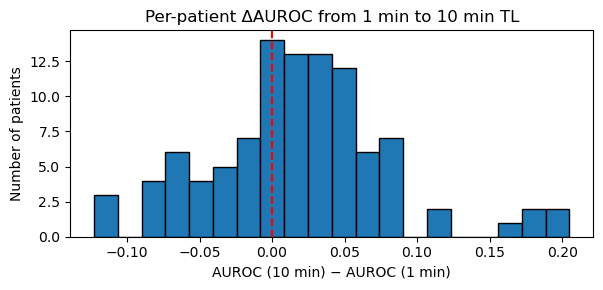

Out of 101 patients:
  • 67 (66.3%) improved (Δ>0)
  • 34 (33.7%) declined (Δ<0)
  • 0 (0.0%) saw no change

Median ΔAUROC = 0.019
Mean   ΔAUROC = 0.018
IQR of Δ   = [-0.023, 0.047]


In [90]:
# ── Cell: Performance delta from 1 min to 10 min adaptation windows ────────────────────

# assume df_tl_drug holds columns [sid, model, auroc, auprc, prev]
# and model ∈ {"TL_1min_drug","TL_10min_drug",…}

# pivot so each row is a sid, columns are the two AUROCs
df1  = df_tl_drug[df_tl_drug.model=="TL_1min_drug"][["sid","auroc"]].rename(columns={"auroc":"auroc_1"})
df10 = df_tl_drug[df_tl_drug.model=="TL_10min_drug"][["sid","auroc"]].rename(columns={"auroc":"auroc_10"})
dfm  = pd.merge(df1, df10, on="sid")
dfm["ΔAUROC"] = dfm.auroc_10 - dfm.auroc_1

# histogram of improvements
plt.figure(figsize=(6,3))
plt.hist(dfm["ΔAUROC"], bins=20, edgecolor="k")
plt.axvline(0, color="r", linestyle="--")
plt.xlabel("AUROC (10 min) − AUROC (1 min)")
plt.ylabel("Number of patients")
plt.title("Per-patient ΔAUROC from 1 min to 10 min TL")
plt.tight_layout()
plt.show()

# assume dfm is your DataFrame with columns ['sid','auroc_1','auroc_10','ΔAUROC']
import numpy as np

# 1) Count how many improved vs. declined vs. unchanged
n_total   = len(dfm)
n_up      = np.sum(dfm["ΔAUROC"]  > 0)
n_down    = np.sum(dfm["ΔAUROC"]  < 0)
n_tie     = np.sum(dfm["ΔAUROC"] == 0)

# 2) Compute summary statistics of the Δ distribution
median_d  = np.median(dfm["ΔAUROC"])
mean_d    = np.mean(dfm["ΔAUROC"])
q1, q3    = np.percentile(dfm["ΔAUROC"], [25,75])

print(f"Out of {n_total} patients:")
print(f"  • {n_up} ({n_up/n_total:.1%}) improved (Δ>0)")
print(f"  • {n_down} ({n_down/n_total:.1%}) declined (Δ<0)")
print(f"  • {n_tie} ({n_tie/n_total:.1%}) saw no change")
print()
print(f"Median ΔAUROC = {median_d:.3f}")
print(f"Mean   ΔAUROC = {mean_d:.3f}")
print(f"IQR of Δ   = [{q1:.3f}, {q3:.3f}]")


In [91]:
# ── Cell: Extract per‐patient post‐adaptation AUROC deltas (10 min − 1 min) ─────────

# Definitions:
#   columns ['sid', 'model', 'auroc', ...]
#   with two models: 'TL_1min_drug' and 'TL_10min_drug'
#   df_tl_drug is the DataFrame with the TL results

# 1) Pull out the 1 min and 10 min AUROCs
df1   = (df_tl_drug
         .loc[df_tl_drug.model=='TL_1min_drug', ['sid','auroc']]
         .rename(columns={'auroc':'auroc_1'}))
df10  = (df_tl_drug
         .loc[df_tl_drug.model=='TL_10min_drug', ['sid','auroc']]
         .rename(columns={'auroc':'auroc_10'}))

# 2) Merge on sid and compute delta
dfm   = pd.merge(df1, df10, on='sid')
dfm['delta_auroc'] = dfm['auroc_10'] - dfm['auroc_1']

# 3) Print the list of deltas for copy‐paste
deltas = dfm['delta_auroc'].round(3).tolist()
print(deltas)


[0.055, -0.061, 0.019, 0.014, 0.033, 0.026, 0.047, 0.028, 0.022, 0.019, -0.076, 0.008, -0.043, -0.042, 0.004, -0.023, 0.056, 0.082, -0.11, 0.029, 0.163, -0.023, 0.068, 0.014, 0.071, -0.062, 0.047, -0.023, -0.062, 0.078, -0.035, -0.051, 0.089, -0.059, 0.085, 0.074, 0.014, 0.088, 0.032, 0.05, 0.085, 0.003, 0.029, 0.012, -0.089, 0.075, 0.205, 0.12, 0.043, -0.038, 0.042, -0.048, 0.068, -0.073, -0.083, -0.118, 0.199, 0.042, 0.054, 0.009, 0.022, -0.033, 0.014, 0.043, 0.178, 0.007, -0.123, 0.041, 0.026, -0.058, 0.062, -0.007, 0.02, 0.031, 0.001, 0.017, 0.111, -0.014, -0.003, 0.043, 0.029, 0.033, 0.003, 0.063, 0.187, 0.003, -0.024, 0.005, -0.039, -0.004, 0.029, -0.01, -0.007, 0.003, -0.038, 0.025, -0.004, 0.023, 0.054, -0.018, -0.076]


AUROC_raw      0.634093
AUROC_platt    0.634093
AUROC_iso      0.634664
Brier_raw      0.201402
Brier_platt    0.170165
Brier_iso      0.169463
ECE_raw        0.150629
ECE_platt      0.019787
ECE_iso        0.000010
dtype: float64


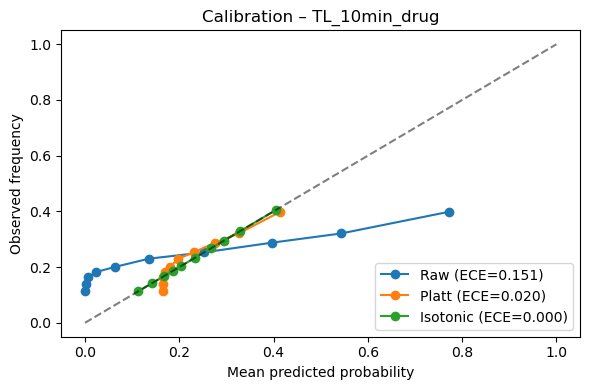

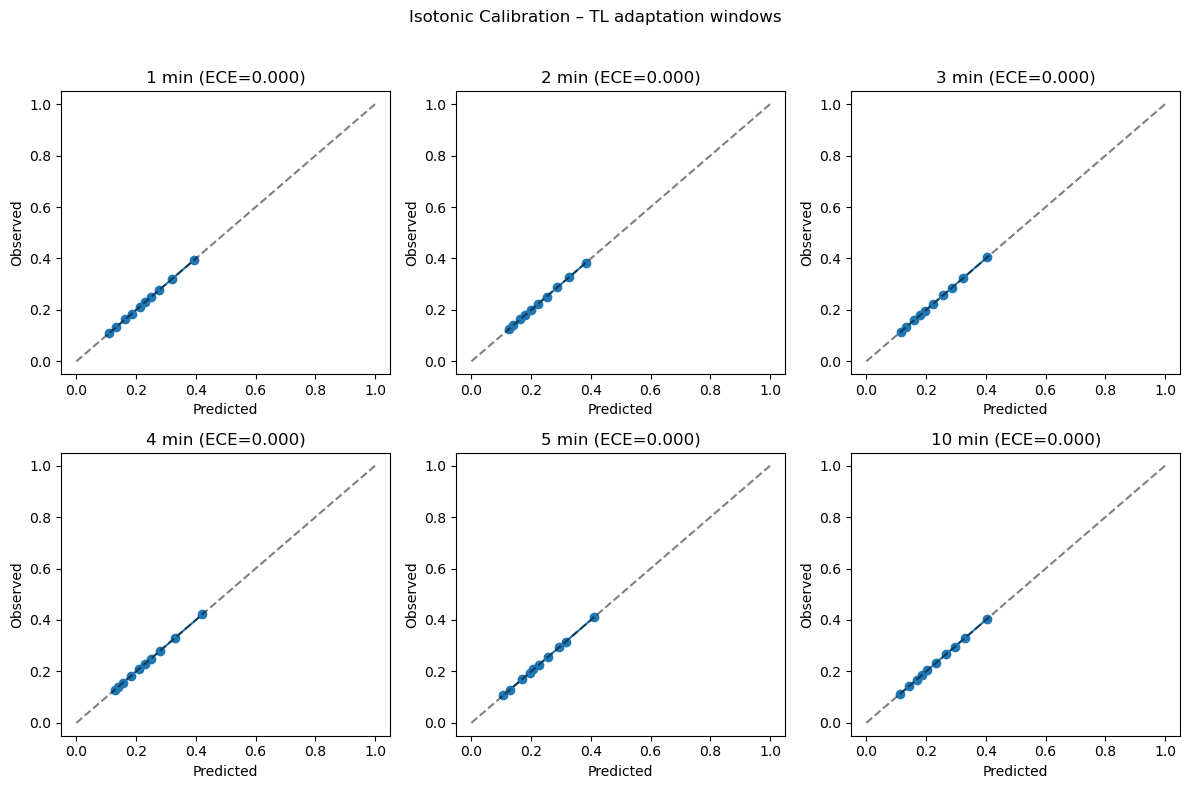

In [97]:
# ── Cell: Calibration comparison & curves for vanilla TL ─────────────────────

from sklearn.isotonic        import IsotonicRegression
from sklearn.calibration     import calibration_curve
from sklearn.metrics         import brier_score_loss
from torch.utils.data        import DataLoader, Subset

# Definitions:
#   full_ds    : Dataset of all (X,y) windows
#   idx_ranges : maps sid → array of global indices
#   TCN, infer, dfs, feat_idx, device

# Revised ECE: use quantile bins so calibration_curve returns exactly n_bins points
def compute_ece(y, p, n_bins=10):
    frac_pos, mean_pred = calibration_curve(y, p,
                                            n_bins=n_bins,
                                            strategy="quantile")
    # equal‐weight per bin
    return np.mean(np.abs(mean_pred - frac_pos))

# ─ 1) Aggregate held-out TL_10min_drug predictions & labels ─────────────────
all_p, all_y = [], []
wins10 = (10 * 60) // 5  # 120 windows

for sid in range(len(dfs)):
    idxs     = idx_ranges(sid)
    eval_idx = idxs[wins10:]
    if len(eval_idx) == 0:
        continue

    # load model
    model = TCN(len(feat_idx)).to(device)
    model.load_state_dict(torch.load(f"chkpt/tl_models/TL_10min_drug_sid{sid}.pt"))
    model.eval()

    ds_eval = Subset(full_ds, eval_idx)
    p, y    = infer(model, DataLoader(ds_eval, batch_size=256, shuffle=False))
    all_p.append(p)
    all_y.append(y)

p_raw  = np.concatenate(all_p)
y_true = np.concatenate(all_y)

# ─ 2) Fit Platt & Isotonic calibrators ───────────────────────────────────────
platt = LogisticRegression().fit(p_raw.reshape(-1,1), y_true)
p_pl   = platt.predict_proba(p_raw.reshape(-1,1))[:,1]

iso    = IsotonicRegression(out_of_bounds='clip').fit(p_raw, y_true)
p_iso  = iso.predict(p_raw)

# ─ 3) Compute metrics ───────────────────────────────────────────────────────
metrics = {
    'AUROC_raw':   roc_auc_score(y_true, p_raw),
    'AUROC_platt': roc_auc_score(y_true, p_pl),
    'AUROC_iso':   roc_auc_score(y_true, p_iso),
    'Brier_raw':   brier_score_loss(y_true, p_raw),
    'Brier_platt': brier_score_loss(y_true, p_pl),
    'Brier_iso':   brier_score_loss(y_true, p_iso),
    'ECE_raw':     compute_ece(y_true, p_raw),
    'ECE_platt':   compute_ece(y_true, p_pl),
    'ECE_iso':     compute_ece(y_true, p_iso),
}
print(pd.Series(metrics))

# ─ 4) Plot reliability curves ───────────────────────────────────────────────
key_map = {'Raw':'ECE_raw','Platt':'ECE_platt','Isotonic':'ECE_iso'}
plt.figure(figsize=(6,4))
for name, probs in [('Raw',p_raw), ('Platt',p_pl), ('Isotonic',p_iso)]:
    frac_pos, mean_pred = calibration_curve(y_true, probs,
                                            n_bins=10,
                                            strategy='quantile')
    ece_val = metrics[key_map[name]]
    plt.plot(mean_pred, frac_pos, marker='o',
             label=f"{name} (ECE={ece_val:.3f})")
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration – TL_10min_drug")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ─ 5) Isotonic calibration curves for multiple TL windows ────────────────────
adapt_list = [1,2,3,4,5,10]
plt.figure(figsize=(12,8))

for i, m in enumerate(adapt_list, 1):
    p_all, y_all = [], []
    wins = (m * 60) // 5

    for sid in range(len(dfs)):
        idxs     = idx_ranges(sid)
        eval_idx = idxs[wins:]
        if len(eval_idx)==0: continue

        model = TCN(len(feat_idx)).to(device)
        model.load_state_dict(torch.load(f"chkpt/tl_models/TL_{m}min_drug_sid{sid}.pt"))
        model.eval()
        p, y = infer(model, DataLoader(Subset(full_ds, eval_idx), batch_size=256, shuffle=False))
        p_all.append(p); y_all.append(y)

    p_raw  = np.concatenate(p_all)
    y_true = np.concatenate(y_all)

    iso      = IsotonicRegression(out_of_bounds='clip').fit(p_raw, y_true)
    p_iso    = iso.predict(p_raw)
    ece_iso  = compute_ece(y_true, p_iso)

    frac_pos, mean_pred = calibration_curve(y_true, p_iso,
                                            n_bins=10,
                                            strategy='quantile')

    ax = plt.subplot(2,3,i)
    ax.plot(mean_pred, frac_pos, marker='o')
    ax.plot([0,1],[0,1],'k--',alpha=0.5)
    ax.set_title(f"{m} min (ECE={ece_iso:.3f})")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Observed")

plt.suptitle("Isotonic Calibration – TL adaptation windows")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [99]:
# ── Cell: Establish statistical significance of TL comparisons ────────────────

from scipy.stats import wilcoxon

# Definitions:
#  - full_ds     : a Dataset of all (X,y) windows concatenated
#  - idx_ranges  : function sid → array of global indices for surgery sid
#  - infer       : helper(model, DataLoader) → (probs, labels)
#  - dfs, feat_idx, device, TCN class
#  - SEED fixed

def compute_ece(y, p, n_bins=10):
    # use equal‐mass bins so calibration_curve returns n_bins points
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=n_bins,
                                            strategy="quantile")
    return np.mean(np.abs(mean_pred - frac_pos))

records = []
wins10 = (10*60)//5  # after 10 min

for sid in range(len(dfs)):
    idxs     = idx_ranges(sid)
    eval_idx = idxs[wins10:]
    if len(eval_idx)==0: 
        continue

    # load the TL model
    model = TCN(len(feat_idx)).to(device)
    model.load_state_dict(torch.load(f"chkpt/tl_models/TL_10min_drug_sid{sid}.pt"))
    model.eval()

    # get raw predictions & labels
    ds_eval = Subset(full_ds, eval_idx)
    p_raw, y_true = infer(model, DataLoader(ds_eval, batch_size=256, shuffle=False))

    # fit Platt
    platt = LogisticRegression().fit(p_raw.reshape(-1,1), y_true)
    p_pl   = platt.predict_proba(p_raw.reshape(-1,1))[:,1]

    # fit Iso
    iso    = IsotonicRegression(out_of_bounds='clip').fit(p_raw, y_true)
    p_iso  = iso.predict(p_raw)

    # compute metrics
    record = {
      "sid":        sid,
      # AUROC
      "raw_auc":    roc_auc_score(y_true, p_raw),
      "platt_auc":  roc_auc_score(y_true, p_pl),
      "iso_auc":    roc_auc_score(y_true, p_iso),
      # Brier
      "raw_brier":  brier_score_loss(y_true, p_raw),
      "platt_brier":brier_score_loss(y_true, p_pl),
      "iso_brier":  brier_score_loss(y_true, p_iso),
      # ECE
      "raw_ece":    compute_ece(y_true, p_raw),
      "platt_ece":  compute_ece(y_true, p_pl),
      "iso_ece":    compute_ece(y_true, p_iso),
    }
    records.append(record)

df = pd.DataFrame(records).set_index("sid")

# 1) Summarize median ±95% CI via bootstrap
def summarize(series):
    med = series.median()
    boots = [series.sample(frac=1, replace=True).median() for _ in range(2000)]
    lo, hi = np.percentile(boots, [2.5,97.5])
    return pd.Series({"median":med, "CI_lower":lo, "CI_upper":hi})

summary = pd.concat([
    summarize(df.raw_auc).rename("raw_auc"),
    summarize(df.platt_auc).rename("platt_auc"),
    summarize(df.iso_auc).rename("iso_auc"),
    summarize(df.raw_brier).rename("raw_brier"),
    summarize(df.platt_brier).rename("platt_brier"),
    summarize(df.iso_brier).rename("iso_brier"),
    summarize(df.raw_ece).rename("raw_ece"),
    summarize(df.platt_ece).rename("platt_ece"),
    summarize(df.iso_ece).rename("iso_ece"),
], axis=1)

print("\nCalibration & performance summary (median ± 95% CI):\n")
print(summary)

# 2) Paired Wilcoxon on the ECE
stat_raw_iso, p_raw_iso   = wilcoxon(df.raw_ece, df.iso_ece)
stat_plat_iso, p_plat_iso = wilcoxon(df.platt_ece, df.iso_ece)
print(f"\nWilcoxon raw vs iso ECE:   stat={stat_raw_iso:.1f}, p={p_raw_iso:.3f}")
print(f"Wilcoxon platt vs iso ECE: stat={stat_plat_iso:.1f}, p={p_plat_iso:.3f}")



Calibration & performance summary (median ± 95% CI):

           raw_auc  platt_auc   iso_auc  raw_brier  platt_brier  iso_brier  \
median    0.649167   0.649442  0.662520   0.195726     0.158417   0.155610   
CI_lower  0.619279   0.632026  0.643919   0.184455     0.155049   0.150785   
CI_upper  0.668893   0.671141  0.681799   0.207681     0.171545   0.164828   

           raw_ece  platt_ece       iso_ece  
median    0.151010   0.050667  7.135036e-09  
CI_lower  0.137979   0.044347  5.577673e-09  
CI_upper  0.170666   0.056316  9.423551e-07  

Wilcoxon raw vs iso ECE:   stat=0.0, p=0.000
Wilcoxon platt vs iso ECE: stat=0.0, p=0.000


In [45]:
# ── Cell: Calibration & Platt‐scaling summary across adaptation windows ──────

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics       import roc_auc_score, average_precision_score
from torch.utils.data      import DataLoader

adapt_list = [1, 2, 3, 4, 5, 10]   # minutes
feat_idx   = np.arange(48)        # drug‐aware
seconds_per_window = 5

summary = []

for m in adapt_list:
    wins = (m * 60) // seconds_per_window   # number of 5-s windows
    skipped = 0

    # per-fold metrics
    auc_uncal, auc_platt = [], []
    prc_uncal,  prc_platt = [], []

    for sid in range(len(dfs)):
        idxs      = idx_ranges(sid)
        adapt_idx = idxs[:wins]
        eval_idx  = idxs[wins:]

        # load fine-tuned TL model for this adaptation window
        ckpt = f"chkpt/tl_models/TL_{m}min_drug_sid{sid}.pt"
        model = TCN(len(feat_idx)).to(device)
        model.load_state_dict(torch.load(ckpt))
        model.eval()

        # infer on adaptation set
        ds_ad = WinDS(X_all[adapt_idx][:, feat_idx], y_all[adapt_idx])
        p_ad, y_ad = infer(model, DataLoader(ds_ad, batch_size=256, shuffle=False))

        # infer on evaluation set
        ds_ev = WinDS(X_all[eval_idx][:, feat_idx], y_all[eval_idx])
        p_ev, y_ev = infer(model, DataLoader(ds_ev, batch_size=256, shuffle=False))

        # uncalibrated metrics
        auc_uncal.append(roc_auc_score(y_ev, p_ev))
        prc_uncal.append(average_precision_score(y_ev, p_ev))

        # try Platt scaling
        if len(np.unique(y_ad)) < 2:
            skipped += 1
            auc_platt.append(np.nan)
            prc_platt.append(np.nan)
        else:
            pl = LogisticRegression().fit(p_ad.reshape(-1,1), y_ad)
            p_pl = pl.predict_proba(p_ev.reshape(-1,1))[:,1]
            auc_platt.append(roc_auc_score(y_ev, p_pl))
            prc_platt.append(average_precision_score(y_ev, p_pl))

    # helper: median and IQR
    def med_iqr(arr):
        a = np.array(arr)
        a = a[~np.isnan(a)]
        return np.median(a), np.percentile(a,75) - np.percentile(a,25)

    auc_u_med, auc_u_iqr = med_iqr(auc_uncal)
    auc_p_med, auc_p_iqr = med_iqr(auc_platt)
    prc_u_med, prc_u_iqr = med_iqr(prc_uncal)
    prc_p_med, prc_p_iqr = med_iqr(prc_platt)

    summary.append({
        "window_min":        m,
        "skipped_folds":     skipped,
        "AUROC_uncal_med":   round(auc_u_med,3),
        "AUROC_uncal_iqr":   round(auc_u_iqr,3),
        "AUROC_platt_med":   round(auc_p_med,3),
        "AUROC_platt_iqr":   round(auc_p_iqr,3),
        "AUPRC_uncal_med":   round(prc_u_med,3),
        "AUPRC_uncal_iqr":   round(prc_u_iqr,3),
        "AUPRC_platt_med":   round(prc_p_med,3),
        "AUPRC_platt_iqr":   round(prc_p_iqr,3),
    })

df_calib_summary = pd.DataFrame(summary).set_index("window_min")
display(df_calib_summary)


,skipped_folds,AUROC_uncal_med,AUROC_uncal_iqr,AUROC_platt_med,AUROC_platt_iqr,AUPRC_uncal_med,AUPRC_uncal_iqr,AUPRC_platt_med,AUPRC_platt_iqr
window_min,,,,,,,,,
1,96,0.641,0.139,0.472,0.206,0.317,0.187,0.223,0.045
2,89,0.640,0.121,0.430,0.148,0.326,0.184,0.197,0.084
3,83,0.650,0.157,0.455,0.237,0.331,0.195,0.178,0.108
4,61,0.634,0.127,0.502,0.246,0.316,0.175,0.240,0.133
5,48,0.639,0.141,0.563,0.245,0.301,0.174,0.257,0.204
10,8,0.649,0.126,0.523,0.282,0.311,0.196,0.239,0.224


In [ ]:
# ── Cell: Full RF‐TL LOSO Ensemble + Metrics ─────────
# Linear combination ensemble.

from sklearn.ensemble         import RandomForestClassifier
from sklearn.metrics          import average_precision_score, precision_recall_curve
from sklearn.calibration      import calibration_curve
import shap

# Definitions:
# full_ds             : PyTorch Dataset returning (X_window, y_label)
# idx_ranges(sid)     : np.array of global indices for surgery sid
# dfs                 : list of length 101
# device              : torch device
# TCN class & infer() : infer(model, dataloader)->(probs, labels)
# --------------------------------------------------------------

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# drug‐aware features are the first 48 physiologic+drug columns
feat_idx_drug = np.arange(48)

# Helper: bootstrap 95% CI for any metric
def bootstrap_ci(y, p, metric, n_boot=2000):
    m = metric(y, p)
    boots = []
    N = len(y)
    for _ in range(n_boot):
        idx = np.random.choice(N, N, replace=True)
        boots.append(metric(y[idx], p[idx]))
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return m, lo, hi

# Manual Grad-CAM for 1D conv layer
class GradCAM:
    def __init__(self, model, layer):
        self.model, self.layer = model, layer
        self.activs, self.grads = None, None
        layer.register_forward_hook(self._fwd_hook)
        layer.register_backward_hook(self._bwd_hook)
    def _fwd_hook(self, _, __, out):      self.activs = out
    def _bwd_hook(self, _, __, grad):     self.grads = grad[0]
    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        out = self.model(x)           # logits
        loss = out[:,class_idx].sum() if class_idx is not None else out.mean()
        loss.backward(retain_graph=True)
        w = self.grads.mean(dim=2, keepdim=True)  # (B,C,1)
        cam = (w * self.activs).sum(dim=1)        # (B,L)
        return cam.detach().cpu().numpy()

# 1) LOSO loop: train RF on-the-fly, load TL, ensemble, collect per-fold results
folds = []
all_rf, all_tl, all_ens, all_y = [], [], [], []

for sid in tqdm(range(len(dfs)), desc="RF‐TL LOSO"):
    test_idx  = idx_ranges(sid)
    train_idx = np.setdiff1d(np.arange(len(full_ds)), test_idx)

    # RF training
    rf = RandomForestClassifier(
        n_estimators   = 200,
        max_features   = "sqrt",
        class_weight   = "balanced",
        random_state   = SEED,
        n_jobs         = -1
    )
    Xtr = np.vstack([full_ds[i][0].numpy() for i in train_idx])[:, feat_idx_drug]
    ytr = np.array([full_ds[i][1].item() for i in train_idx])
    rf.fit(Xtr, ytr)

    # TL loading (10-min drug-aware)
    tl = TCN(len(feat_idx_drug)).to(device)
    tl.load_state_dict(torch.load(f"chkpt/tl_models/TL_10min_drug_sid{sid}.pt"))
    tl.eval()

    # Prepare test set
    Xte = np.vstack([full_ds[i][0].numpy() for i in test_idx])
    yte = np.array([full_ds[i][1].item() for i in test_idx])
    dl  = DataLoader(Subset(full_ds, test_idx), batch_size=256, shuffle=False)

    # Predictions
    prf, _ = rf.predict_proba(Xte[:, feat_idx_drug])[:,1], None
    ptl, _ = infer(tl, dl)
    pens   = 0.5 * prf + 0.5 * ptl

    # Record per-fold metrics
    folds.append({
        "sid":       sid,
        "RF_AUROC":  roc_auc_score(yte, prf),
        "TL_AUROC":  roc_auc_score(yte, ptl),
        "ENS_AUROC": roc_auc_score(yte, pens),
        "RF_AUPRC":  average_precision_score(yte, prf),
        "TL_AUPRC":  average_precision_score(yte, ptl),
        "ENS_AUPRC": average_precision_score(yte, pens),
    })
    all_rf .append(prf)
    all_tl .append(ptl)
    all_ens.append(pens)
    all_y  .append(yte)

df_f = pd.DataFrame(folds).set_index("sid")
display(df_f)

# 2) Pooled metrics + 95% CIs
y_all = np.concatenate(all_y)
for name, preds in [("RF", all_rf), ("TL", all_tl), ("ENS", all_ens)]:
    p = np.concatenate(preds)
    auc, alo, ahi = bootstrap_ci(y_all, p, roc_auc_score)
    prc, plo, phi = bootstrap_ci(y_all, p, average_precision_score)
    print(f"{name} AUROC = {auc:.3f} ({alo:.3f}–{ahi:.3f}), "
          f"AUPRC = {prc:.3f} ({plo:.3f}–{phi:.3f})")

# 3) Wilcoxon paired AUROC
print("\nWilcoxon ENS vs RF:", wilcoxon(df_f.ENS_AUROC, df_f.RF_AUROC))
print("Wilcoxon ENS vs TL:", wilcoxon(df_f.ENS_AUROC, df_f.TL_AUROC))


RF‐TL LOSO:   0%|          | 0/101 [00:00<?, ?it/s]

,RF_AUROC,TL_AUROC,ENS_AUROC,RF_AUPRC,TL_AUPRC,ENS_AUPRC
sid,,,,,,
0,0.851152,0.592115,0.743464,0.432029,0.154775,0.225917
1,0.778848,0.693861,0.732970,0.465174,0.415166,0.455145
2,0.782795,0.738673,0.776129,0.371967,0.335736,0.360916
3,0.727614,0.677964,0.708639,0.441383,0.382684,0.439461
4,0.808613,0.709996,0.757927,0.532150,0.373100,0.450131
...,...,...,...,...,...,...
96,0.793403,0.673890,0.730938,0.487189,0.404573,0.452327
97,0.658540,0.683026,0.693890,0.436435,0.442962,0.451477
98,0.816753,0.710351,0.761510,0.636965,0.452757,0.540940


RF AUROC = 0.713 (0.711–0.716), AUPRC = 0.415 (0.410–0.419)
TL AUROC = 0.635 (0.632–0.637), AUPRC = 0.323 (0.319–0.326)
ENS AUROC = 0.683 (0.681–0.686), AUPRC = 0.372 (0.367–0.376)

Wilcoxon ENS vs RF: WilcoxonResult(statistic=np.float64(1184.0), pvalue=np.float64(2.4302417699599884e-06))
Wilcoxon ENS vs TL: WilcoxonResult(statistic=np.float64(417.0), pvalue=np.float64(2.627765205307988e-13))


In [ ]:
plan:
do 1 min RF-TL LOSO

then:
do 10 min RF-TL LOSO but with prune RF to lower memory requirements and see if it perform similarly

what would be the best way to quantify computational burden and size of models - make an argument for feasibility and scalability

In [9]:
# --- Cell: Regular pruned RF-TL (50 trees), no meta-learner ---    
# Results: Regular pruned RF-TL (50 trees) does not perform similarly to RF.
# Linear combination ensemble.

from sklearn.model_selection import KFold

# Definitions:  
# full_ds, idx_ranges, dfs, device, TCN class, infer()
# --------------------------------------------------

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# drug-aware feature indices
feat_idx = np.arange(48)

def bootstrap_ci(y, p, metric, n_boot=500):
    m = metric(y, p)
    boots = []
    N = len(y)
    for _ in range(n_boot):
        idx = np.random.choice(N, N, replace=True)
        boots.append(metric(y[idx], p[idx]))
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return m, lo, hi

# Pruned RF + weight-tuned ensemble in LOSO
records = []
all_ens, all_rf, all_tl, all_y = [], [], [], []

for sid in tqdm(range(len(dfs)),w desc="Pruned RF-TL LOSO"):
    test_idx  = idx_ranges(sid)
    train_idx = np.setdiff1d(np.arange(len(full_ds)), test_idx)

    # 1) Pruned RF
    rf = RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        max_features=0.25,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    )
    Xtr = np.vstack([full_ds[i][0].numpy() for i in train_idx])[:, feat_idx]
    ytr = np.array([full_ds[i][1].item() for i in train_idx])
    rf.fit(Xtr, ytr)

    # 2) Load TL (10min, drug-aware)
    tl = TCN(len(feat_idx)).to(device)
    tl.load_state_dict(torch.load(f"chkpt/tl_models/TL_10min_drug_sid{sid}.pt"))
    tl.eval()

    # 3) Generate RF/TL train predictions for weight search
    prf_tr = rf.predict_proba(Xtr)[:,1]
    ptl_tr = []
    dl_tr  = DataLoader(Subset(full_ds, train_idx), batch_size=512, shuffle=False)
    with torch.no_grad():
        for xb,yb in dl_tr:
            xb = xb.to(device)
            p_batch, _ = infer(tl, [(xb,yb)])
            ptl_tr.append(p_batch)
    ptl_tr = np.concatenate(ptl_tr)

    # 4) 5-fold CV on train_idx to pick best alpha
    kf = KFold(5, shuffle=True, random_state=SEED)
    best_alpha, best_score = 0.5, -np.inf
    for alpha in np.linspace(0,1,11):
        aucs = []
        for tr, val in kf.split(train_idx):
            ens_val = alpha*prf_tr[val] + (1-alpha)*ptl_tr[val]
            aucs.append(roc_auc_score(ytr[val], ens_val))
        m = np.mean(aucs)
        if m > best_score:
            best_score, best_alpha = m, alpha

    # 5) Test‐set predictions
    Xte = np.vstack([full_ds[i][0].numpy() for i in test_idx])[:, feat_idx]
    yte = np.array([full_ds[i][1].item() for i in test_idx])
    dl_te = DataLoader(Subset(full_ds, test_idx), batch_size=512, shuffle=False)

    prf_te = rf.predict_proba(Xte)[:,1]
    ptl_te = []
    with torch.no_grad():
        for xb,yb in dl_te:
            xb = xb.to(device)
            p_batch, _ = infer(tl, [(xb,yb)])
            ptl_te.append(p_batch)
    ptl_te = np.concatenate(ptl_te)

    ens_te = best_alpha*prf_te + (1-best_alpha)*ptl_te

    # 6) Record
    records.append({
      "sid":       sid,
      "alpha":     best_alpha,
      "RF_AUROC":  roc_auc_score(yte, prf_te),
      "TL_AUROC":  roc_auc_score(yte, ptl_te),
      "ENS_AUROC": roc_auc_score(yte, ens_te),
      "RF_AUPRC":  average_precision_score(yte, prf_te),
      "TL_AUPRC":  average_precision_score(yte, ptl_te),
      "ENS_AUPRC": average_precision_score(yte, ens_te),
    })
    all_rf .append(prf_te)
    all_tl .append(ptl_te)
    all_ens.append(ens_te)
    all_y  .append(yte)

df = pd.DataFrame(records).set_index("sid")
display(df)

# Pooled metrics + 95% CIs
y_all = np.concatenate(all_y)
for name, arr in [("RF", all_rf), ("TL", all_tl), ("ENS", all_ens)]:
    p = np.concatenate(arr)
    auc, lo, hi = bootstrap_ci(y_all, p, roc_auc_score)
    prc, plo, phi = bootstrap_ci(y_all, p, average_precision_score)
    print(f"{name} AUROC={auc:.3f} ({lo:.3f}–{hi:.3f}), "
          f"AUPRC={prc:.3f} ({plo:.3f}–{phi:.3f})")

# Paired Wilcoxon on AUROC
print("Wilcoxon ENS>RF:", wilcoxon(df.ENS_AUROC, df.RF_AUROC))
print("Wilcoxon ENS>TL:", wilcoxon(df.ENS_AUROC, df.TL_AUROC))


Pruned RF-TL LOSO:   0%|          | 0/101 [00:00<?, ?it/s]

,alpha,RF_AUROC,TL_AUROC,ENS_AUROC,RF_AUPRC,TL_AUPRC,ENS_AUPRC
sid,,,,,,,
0,0.4,0.856557,0.592115,0.747571,0.486014,0.154775,0.229043
1,0.4,0.815189,0.693861,0.754105,0.520384,0.415166,0.484832
2,0.3,0.783238,0.738673,0.769881,0.338976,0.335736,0.354599
3,0.4,0.729501,0.677964,0.716079,0.442013,0.382684,0.435064
4,0.4,0.823047,0.709996,0.763630,0.546608,0.373100,0.438391
...,...,...,...,...,...,...,...
96,0.3,0.783087,0.673890,0.715729,0.500188,0.404573,0.437958
97,0.4,0.705848,0.683026,0.709027,0.463204,0.442962,0.459084
98,0.4,0.784985,0.710351,0.749464,0.600793,0.452757,0.526230


RF AUROC=0.715 (0.713–0.718), AUPRC=0.409 (0.404–0.413)
TL AUROC=0.635 (0.632–0.637), AUPRC=0.323 (0.319–0.327)
ENS AUROC=0.681 (0.679–0.684), AUPRC=0.359 (0.355–0.363)
Wilcoxon ENS>RF: WilcoxonResult(statistic=1226.0, pvalue=4.839778774989733e-06)
Wilcoxon ENS>TL: WilcoxonResult(statistic=462.0, pvalue=8.081243334373433e-13)


In [13]:
# ── Full LOSO Stacking Experiment (non-pruned RF (100 trees) + TL + Meta‐Learner) ────────────────────
# Results: For some reason, this improved the AUROC of the ensemble model but not the RF. This might be due to the 
# meta learner, and the error diversity of the 200-tree RF might allow the meta-learner to learn better. More trees
# might not help much, but in the ensemble, the subtle improvements in the AUROC and the error diversity might help. 

# Definitions 
# full_ds            : PyTorch Dataset yielding (X_window, y_label)
# idx_ranges(sid)    : function → np.array of window indices for surgery sid
# dfs                : list of length 101 (one entry per surgery)
# device             : torch.device
# TCN class & infer  : infer(model, DataLoader) → (probs, labels)
# feat_idx_drug      : np.arange(48)  # drug-aware feature columns
# --------------------------------------------------------------

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
feat_idx_drug = np.arange(48)

# Helper to compute bootstrap 95% CI
def bootstrap_ci(y, p, metric, n_boot=1000):
    m = metric(y, p)
    boots = []
    N = len(y)
    for _ in range(n_boot):
        idx = np.random.choice(N, N, replace=True)
        boots.append(metric(y[idx], p[idx]))
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return m, lo, hi

records = []
all_rf, all_tl, all_meta, all_y = [], [], [], []

for sid in tqdm(range(len(dfs)), desc="LOSO Stacking (101 folds)"):
    # 1) Build LOSO train/test splits
    test_idx  = idx_ranges(sid)
    train_idx = np.setdiff1d(np.arange(len(full_ds)), test_idx)

    # 2) Train RF on train split (drug-aware features)
    rf = RandomForestClassifier(
        n_estimators   = 200,
        max_features   = "sqrt",
        class_weight   = "balanced",
        random_state   = SEED,
        n_jobs         = -1
    )
    X_tr = np.vstack([full_ds[i][0].numpy() for i in train_idx])[:, feat_idx_drug]
    y_tr = np.array([full_ds[i][1].item() for i in train_idx])
    rf.fit(X_tr, y_tr)

    # 3) Load pre-trained TL (10-min, drug-aware) and get train predictions
    tl = TCN(len(feat_idx_drug)).to(device)
    tl.load_state_dict(torch.load(f"chkpt/tl_models/TL_10min_drug_sid{sid}.pt"))
    tl.eval()
    p_tl_tr = []
    dl_tr   = DataLoader(Subset(full_ds, train_idx), batch_size=512, shuffle=False)
    with torch.no_grad():
        for xb, yb in dl_tr:
            xb = xb.to(device)
            p_batch, _ = infer(tl, [(xb, yb)])
            p_tl_tr.append(p_batch)
    p_tl_tr = np.concatenate(p_tl_tr)

    p_rf_tr = rf.predict_proba(X_tr)[:,1]

    # 4) Fit meta-learner on stacked [p_rf_tr, p_tl_tr]
    meta = LogisticRegression(solver="liblinear")
    meta.fit(np.stack([p_rf_tr, p_tl_tr], axis=1), y_tr)

    # 5) Evaluate all three on held-out surgery
    X_te = np.vstack([full_ds[i][0].numpy() for i in test_idx])[:, feat_idx_drug]
    y_te = np.array([full_ds[i][1].item() for i in test_idx])
    dl_te = DataLoader(Subset(full_ds, test_idx), batch_size=512, shuffle=False)

    p_rf_te = rf.predict_proba(X_te)[:,1]
    p_tl_te = []
    with torch.no_grad():
        for xb, yb in dl_te:
            xb = xb.to(device)
            p_batch, _ = infer(tl, [(xb, yb)])
            p_tl_te.append(p_batch)
    p_tl_te = np.concatenate(p_tl_te)

    p_meta = meta.predict_proba(np.stack([p_rf_te, p_tl_te], axis=1))[:,1]

    # 6) Record fold metrics and store predictions
    records.append({
        "sid":         sid,
        "RF_AUROC":    roc_auc_score(y_te, p_rf_te),
        "TL_AUROC":    roc_auc_score(y_te, p_tl_te),
        "META_AUROC":  roc_auc_score(y_te, p_meta),
        "RF_AUPRC":    average_precision_score(y_te, p_rf_te),
        "TL_AUPRC":    average_precision_score(y_te, p_tl_te),
        "META_AUPRC":  average_precision_score(y_te, p_meta),
    })
    all_rf   .append(p_rf_te)
    all_tl   .append(p_tl_te)
    all_meta .append(p_meta)
    all_y    .append(y_te)

# 7) Summarize per-fold results
df = pd.DataFrame(records).set_index("sid")
print("Per-fold LOSO stacking results:")
display(df)

# 8) Compute pooled metrics + 95% CIs
y_all = np.concatenate(all_y)
for name, arr in [("RF", all_rf), ("TL", all_tl), ("META", all_meta)]:
    p_all   = np.concatenate(arr)
    auc, alo, ahi  = bootstrap_ci(y_all, p_all, roc_auc_score)
    prc, plo, phi  = bootstrap_ci(y_all, p_all, average_precision_score)
    print(f"{name} pooled → AUROC = {auc:.3f} ({alo:.3f}–{ahi:.3f}), "
          f"AUPRC = {prc:.3f} ({plo:.3f}–{phi:.3f})")

# 9) Paired Wilcoxon tests on AUROC
print("\nWilcoxon META vs RF:", wilcoxon(df["META_AUROC"], df["RF_AUROC"]))
print("Wilcoxon META vs TL:", wilcoxon(df["META_AUROC"], df["TL_AUROC"]))

LOSO Stacking (101 folds):   0%|          | 0/101 [00:00<?, ?it/s]

Per-fold LOSO stacking results:


,RF_AUROC,TL_AUROC,META_AUROC,RF_AUPRC,TL_AUPRC,META_AUPRC
sid,,,,,,
0,0.851152,0.592115,0.856467,0.432029,0.154775,0.444606
1,0.778848,0.693861,0.773101,0.465174,0.415166,0.457628
2,0.782795,0.738673,0.779354,0.371967,0.335736,0.367915
3,0.727614,0.677964,0.723817,0.441383,0.382684,0.435654
4,0.808613,0.709996,0.805642,0.532150,0.373100,0.534189
...,...,...,...,...,...,...
96,0.793403,0.673890,0.791470,0.487189,0.404573,0.483978
97,0.658540,0.683026,0.631582,0.436435,0.442962,0.424383
98,0.816753,0.710351,0.813005,0.636965,0.452757,0.642889


RF pooled → AUROC = 0.713 (0.711–0.716), AUPRC = 0.415 (0.410–0.419)
TL pooled → AUROC = 0.635 (0.632–0.637), AUPRC = 0.323 (0.319–0.327)
META pooled → AUROC = 0.708 (0.706–0.711), AUPRC = 0.413 (0.409–0.418)

Wilcoxon META vs RF: WilcoxonResult(statistic=1306.0, pvalue=1.7033260068538852e-05)
Wilcoxon META vs TL: WilcoxonResult(statistic=888.0, pvalue=1.0865292076292706e-08)


In [14]:
# ── Cell: Pruned RF-TL (50 trees) + Meta-Learner ────────────────────
# Results: The meta-learner wasn't the one that actually improved the AUROC, it seems. The AUROC returned to the
# prior 50-tree RF-TL with no meta-learner. The 50-tree RF-TL with meta-learner didn't do better at all, suggesting
# the 200-tree version is indeed better. 

# Definitions:
# full_ds            : Dataset yielding (X_window, y_label)
# idx_ranges(sid)    : function → np.array of window indices for surgery sid
# dfs                : list of length 101
# device             : torch.device
# TCN class & infer  : infer(model, dataloader)->(probs, labels)
# feat_idx_drug      : np.arange(48)  # drug-aware feature columns
# --------------------------------------------------------------

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

def bootstrap_ci(y, p, metric, n_boot=1000):
    base = metric(y, p)
    boots = []
    N = len(y)
    for _ in range(n_boot):
        idx = np.random.choice(N, N, replace=True)
        boots.append(metric(y[idx], p[idx]))
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return base, lo, hi

records = []
all_rf, all_tl, all_meta, all_y = [], [], [], []

for sid in tqdm(range(len(dfs)), desc="Pruned RF‐TL Stacking LOSO"):
    # train/test split
    test_idx  = idx_ranges(sid)
    train_idx = np.setdiff1d(np.arange(len(full_ds)), test_idx)

    # 1) Pruned RF
    rf = RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        max_features=0.25,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    )
    X_tr = np.vstack([full_ds[i][0].numpy() for i in train_idx])[:, feat_idx_drug]
    y_tr = np.array([full_ds[i][1].item() for i in train_idx])
    rf.fit(X_tr, y_tr)

    # 2) Load TL and get train predictions
    tl = TCN(len(feat_idx_drug)).to(device)
    tl.load_state_dict(torch.load(f"chkpt/tl_models/TL_10min_drug_sid{sid}.pt"))
    tl.eval()
    p_tl_tr = []
    dl_tr = DataLoader(Subset(full_ds, train_idx), batch_size=512, shuffle=False)
    with torch.no_grad():
        for xb, yb in dl_tr:
            xb = xb.to(device)
            p_batch, _ = infer(tl, [(xb, yb)])
            p_tl_tr.append(p_batch)
    p_tl_tr = np.concatenate(p_tl_tr)
    p_rf_tr = rf.predict_proba(X_tr)[:,1]

    # 3) Fit meta‐learner
    meta = LogisticRegression(solver="liblinear")
    meta.fit(np.stack([p_rf_tr, p_tl_tr], axis=1), y_tr)

    # 4) Evaluate on held-out fold
    X_te = np.vstack([full_ds[i][0].numpy() for i in test_idx])[:, feat_idx_drug]
    y_te = np.array([full_ds[i][1].item() for i in test_idx])
    dl_te = DataLoader(Subset(full_ds, test_idx), batch_size=512, shuffle=False)

    p_rf_te = rf.predict_proba(X_te)[:,1]
    p_tl_te = []
    with torch.no_grad():
        for xb, yb in dl_te:
            xb = xb.to(device)
            p_batch, _ = infer(tl, [(xb, yb)])
            p_tl_te.append(p_batch)
    p_tl_te = np.concatenate(p_tl_te)
    p_meta = meta.predict_proba(np.stack([p_rf_te, p_tl_te], axis=1))[:,1]

    # 5) Record metrics
    records.append({
        "sid":        sid,
        "RF_AUROC":   roc_auc_score(y_te, p_rf_te),
        "TL_AUROC":   roc_auc_score(y_te, p_tl_te),
        "META_AUROC": roc_auc_score(y_te, p_meta),
        "RF_AUPRC":   average_precision_score(y_te, p_rf_te),
        "TL_AUPRC":   average_precision_score(y_te, p_tl_te),
        "META_AUPRC": average_precision_score(y_te, p_meta),
    })
    all_rf  .append(p_rf_te)
    all_tl  .append(p_tl_te)
    all_meta.append(p_meta)
    all_y   .append(y_te)

# per-fold results
df = pd.DataFrame(records).set_index("sid")
print("Per-fold pruned RF-TL stacking results:")
display(df)

# pooled performance + 95% CIs
y_all = np.concatenate(all_y)
for name, arr in [("RF", all_rf), ("TL", all_tl), ("META", all_meta)]:
    p_all = np.concatenate(arr)
    auc, lo, hi = bootstrap_ci(y_all, p_all, roc_auc_score)
    prc, plo, phi = bootstrap_ci(y_all, p_all, average_precision_score)
    print(f"{name} pooled → AUROC = {auc:.3f} ({lo:.3f}–{hi:.3f}), "
          f"AUPRC = {prc:.3f} ({plo:.3f}–{phi:.3f})")

# statistical tests
print("\nWilcoxon META vs RF:", wilcoxon(df["META_AUROC"], df["RF_AUROC"]))
print("Wilcoxon META vs TL:", wilcoxon(df["META_AUROC"], df["TL_AUROC"]))

Pruned RF‐TL Stacking LOSO:   0%|          | 0/101 [00:00<?, ?it/s]

Per-fold pruned RF-TL stacking results:


,RF_AUROC,TL_AUROC,META_AUROC,RF_AUPRC,TL_AUPRC,META_AUPRC
sid,,,,,,
0,0.856557,0.592115,0.753564,0.486014,0.154775,0.234361
1,0.815189,0.693861,0.759134,0.520384,0.415166,0.490117
2,0.783238,0.738673,0.778083,0.338976,0.335736,0.362541
3,0.729501,0.677964,0.716853,0.442013,0.382684,0.436310
4,0.823047,0.709996,0.763317,0.546608,0.373100,0.437845
...,...,...,...,...,...,...
96,0.783087,0.673890,0.733554,0.500188,0.404573,0.454176
97,0.705848,0.683026,0.709842,0.463204,0.442962,0.460292
98,0.784985,0.710351,0.751037,0.600793,0.452757,0.529531


RF pooled → AUROC = 0.715 (0.713–0.718), AUPRC = 0.409 (0.404–0.413)
TL pooled → AUROC = 0.635 (0.632–0.637), AUPRC = 0.323 (0.319–0.327)
META pooled → AUROC = 0.686 (0.684–0.688), AUPRC = 0.365 (0.361–0.369)

Wilcoxon META vs RF: WilcoxonResult(statistic=1332.0, pvalue=2.5253037184219463e-05)
Wilcoxon META vs TL: WilcoxonResult(statistic=480.0, pvalue=1.258514095834774e-12)


In [16]:
# --- Cell: MLP-Meta Stacking LOSO, two-layer meta-learner with regular (200 trees) RF-TL  ---
# Prior one was logistic regression, this one is MLP. Non-linear combination of RF and TL. 
# Results:  AUROC and AUPRC are both improved from pruned, and similar to 200-tree RF-TL
# with or without meta-learner. However, one thing to note is that the logistic regression
# meta-learner ensemble was still inferior with statistical significance to regular RF. 
# However, this one performed as well as the 200-tree RF with no statistical difference. 

import torch
import torch.nn as nn
import torch.optim as optim

# Definitions:
# full_ds            : Dataset yielding (X_window, y_label)
# idx_ranges(sid)    : function → np.array of window indices for surgery sid
# dfs                : list of 101 surgeries
# device             : torch.device
# TCN class & infer  : infer(model, dataloader)->(probs, labels)
# feat_idx_drug      : np.arange(48)
# --------------------------------------------------------------

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# define a small MLP meta-learner
class MetaMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

# helper for bootstrap CI
def bootstrap_ci(y, p, metric, n_boot=500):
    m = metric(y,p)
    boots=[]
    N=len(y)
    for _ in range(n_boot):
        idx=np.random.choice(N,N,replace=True)
        boots.append(metric(y[idx],p[idx]))
    lo,hi = np.percentile(boots,[2.5,97.5])
    return m, lo, hi

records=[]
all_rf, all_tl, all_meta, all_y = [], [], [], []

for sid in tqdm(range(len(dfs)), desc="MLP-Meta Stacking LOSO"):
    test_idx  = idx_ranges(sid)
    train_idx = np.setdiff1d(np.arange(len(full_ds)), test_idx)

    # 1) Train RF
    rf = RandomForestClassifier(
        n_estimators=200,
        max_features="sqrt",
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    )
    X_tr = np.vstack([full_ds[i][0].numpy() for i in train_idx])[:, feat_idx_drug]
    y_tr = np.array([full_ds[i][1].item() for i in train_idx])
    rf.fit(X_tr, y_tr)

    # 2) Load TL & get train preds
    tl = TCN(len(feat_idx_drug)).to(device)
    tl.load_state_dict(torch.load(f"chkpt/tl_models/TL_10min_drug_sid{sid}.pt"))
    tl.eval()
    p_tl_tr=[]
    dl_tr = DataLoader(Subset(full_ds, train_idx), batch_size=256, shuffle=False)
    with torch.no_grad():
        for xb,yb in dl_tr:
            xb=xb.to(device)
            p_batch,_ = infer(tl,[(xb,yb)])
            p_tl_tr.append(p_batch)
    p_tl_tr = np.concatenate(p_tl_tr)
    p_rf_tr = rf.predict_proba(X_tr)[:,1]

    # 3) Prepare meta-dataset
    X_meta_tr = torch.from_numpy(np.stack([p_rf_tr,p_tl_tr],axis=1)).float()
    y_meta_tr = torch.from_numpy(y_tr).float()

    ds_meta = TensorDataset(X_meta_tr, y_meta_tr)
    dl_meta = DataLoader(ds_meta, batch_size=1024, shuffle=True)

    # 4) Train Meta-MLP
    meta = MetaMLP().to(device)
    opt = optim.Adam(meta.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()
    meta.train()
    for epoch in range(10):
        for xb,yb in dl_meta:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = meta(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

    # 5) Evaluate on test split
    X_te = np.vstack([full_ds[i][0].numpy() for i in test_idx])[:, feat_idx_drug]
    y_te = np.array([full_ds[i][1].item() for i in test_idx])
    dl_te = DataLoader(Subset(full_ds, test_idx), batch_size=256, shuffle=False)

    p_rf_te = rf.predict_proba(X_te)[:,1]
    p_tl_te=[]
    with torch.no_grad():
        for xb,yb in dl_te:
            xb=xb.to(device)
            p_batch,_ = infer(tl,[(xb,yb)])
            p_tl_te.append(p_batch)
    p_tl_te = np.concatenate(p_tl_te)

    # MLP meta inference
    meta.eval()
    with torch.no_grad():
        inp = torch.from_numpy(np.stack([p_rf_te,p_tl_te],axis=1)).float().to(device)
        p_meta = torch.sigmoid(meta(inp)).cpu().numpy()

    # record
    records.append({
        "sid":        sid,
        "RF_AUROC":   roc_auc_score(y_te, p_rf_te),
        "TL_AUROC":   roc_auc_score(y_te, p_tl_te),
        "META_AUROC": roc_auc_score(y_te, p_meta),
        "RF_AUPRC":   average_precision_score(y_te, p_rf_te),
        "TL_AUPRC":   average_precision_score(y_te, p_tl_te),
        "META_AUPRC": average_precision_score(y_te, p_meta),
    })
    all_rf  .append(p_rf_te)
    all_tl  .append(p_tl_te)
    all_meta.append(p_meta)
    all_y   .append(y_te)

# compile results
df = pd.DataFrame(records).set_index("sid")
display(df)

# pooled
y_all = np.concatenate(all_y)
for name, arr in [("RF",all_rf),("TL",all_tl),("META",all_meta)]:
    p_all = np.concatenate(arr)
    auc,lo,hi = bootstrap_ci(y_all,p_all,roc_auc_score)
    prc,plo,phi = bootstrap_ci(y_all,p_all,average_precision_score)
    print(f"{name} pooled → AUROC={auc:.3f} ({lo:.3f}–{hi:.3f}), "
          f"AUPRC={prc:.3f} ({plo:.3f}–{phi:.3f})")

# stats
print("Wilcoxon META>RF:", wilcoxon(df.META_AUROC, df.RF_AUROC))
print("Wilcoxon META>TL:", wilcoxon(df.META_AUROC, df.TL_AUROC))


MLP-Meta Stacking LOSO:   0%|          | 0/101 [00:00<?, ?it/s]

,RF_AUROC,TL_AUROC,META_AUROC,RF_AUPRC,TL_AUPRC,META_AUPRC
sid,,,,,,
0,0.851152,0.592115,0.821920,0.432029,0.154775,0.349907
1,0.778848,0.693861,0.772456,0.465174,0.415166,0.470315
2,0.782795,0.738673,0.764857,0.371967,0.335736,0.361391
3,0.727614,0.677964,0.728396,0.441383,0.382684,0.448383
4,0.808613,0.709996,0.803193,0.532150,0.373100,0.525068
...,...,...,...,...,...,...
96,0.793403,0.673890,0.790138,0.487189,0.404573,0.490991
97,0.658540,0.683026,0.677122,0.436435,0.442962,0.450785
98,0.816753,0.710351,0.816484,0.636965,0.452757,0.638064


RF pooled → AUROC=0.713 (0.711–0.716), AUPRC=0.415 (0.410–0.419)
TL pooled → AUROC=0.635 (0.632–0.637), AUPRC=0.323 (0.319–0.327)
META pooled → AUROC=0.710 (0.708–0.713), AUPRC=0.415 (0.411–0.420)
Wilcoxon META>RF: WilcoxonResult(statistic=2214.0, pvalue=0.22071440788784424)
Wilcoxon META>TL: WilcoxonResult(statistic=660.0, pvalue=8.639758876008318e-11)


In [8]:
# ── Cell: LOSO Ensemble with Feature‐Conditioned Gating Network ─────────────────────
# Same 200-tree RF-TL, but this time with a gating network to combine the predictions. 
# Gating network uses weighted sum to combine the RF-TL instead of doing a simple ensemble. 
# Results: Performance improved non-statistically significant. 

# Definitions:
# full_ds            : Dataset yielding (X_window, y_label)
# idx_ranges(sid)    : function → np.array of window‐indices for surgery sid
# dfs                : list of length 101
# device             : torch.device
# TCN class & infer  : infer(model, dataloader)->(probs,labels)
# feat_idx_drug      : np.arange(48)
# --------------------------------------------------------------

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
feat_idx_drug = np.arange(48)

# GateNet: 48 → 16 → 1, Sigmoid output α(x)
class GateNet(nn.Module):
    def __init__(self, in_dim=48):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

# Helper for bootstrap CI
def bootstrap_ci(y, p, metric, n_boot=500):
    m = metric(y, p)
    boots = []
    N = len(y)
    for _ in range(n_boot):
        idx = np.random.choice(N, N, replace=True)
        boots.append(metric(y[idx], p[idx]))
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return m, lo, hi

records = []
all_rf, all_tl, all_gate, all_y = [], [], [], []

for sid in tqdm(range(len(dfs)), desc="Gated RF-TL LOSO"):
    # 1) Train/test split indices
    test_idx  = idx_ranges(sid)
    train_idx = np.setdiff1d(np.arange(len(full_ds)), test_idx)

    # 2) Fit RF on train set
    rf = RandomForestClassifier(
        n_estimators=200,
        max_features="sqrt",
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    )
    X_tr = np.vstack([full_ds[i][0].numpy() for i in train_idx])[:, feat_idx_drug]
    y_tr = np.array([full_ds[i][1].item() for i in train_idx])
    rf.fit(X_tr, y_tr)

    # 3) Load TL and get its train predictions
    tl = TCN(len(feat_idx_drug)).to(device)
    tl.load_state_dict(torch.load(f"chkpt/tl_models/TL_10min_drug_sid{sid}.pt"))
    tl.eval()
    p_tl_tr = []
    dl_tr = DataLoader(Subset(full_ds, train_idx), batch_size=512, shuffle=False)
    with torch.no_grad():
        for xb, yb in dl_tr:
            xb = xb.to(device)
            p_batch, _ = infer(tl, [(xb, yb)])
            p_tl_tr.append(p_batch)
    p_tl_tr = np.concatenate(p_tl_tr)
    p_rf_tr = rf.predict_proba(X_tr)[:,1]

    # 4) Train GateNet on (X_tr → blend p_rf_tr/p_tl_tr → match y_tr)
    gate = GateNet(in_dim=len(feat_idx_drug)).to(device)
    opt  = optim.Adam(gate.parameters(), lr=1e-3)
    loss_fn = nn.BCELoss()

    # Create DataLoader for gating
    Xg = torch.from_numpy(X_tr).float()
    yg = torch.from_numpy(y_tr).float()
    pg_rf = torch.from_numpy(p_rf_tr).float()
    pg_tl = torch.from_numpy(p_tl_tr).float()
    ds_g = TensorDataset(Xg, pg_rf, pg_tl, yg)
    dl_g = DataLoader(ds_g, batch_size=1024, shuffle=True)

    gate.train()
    for epoch in range(5):
        for xb, prf_b, ptl_b, yb in dl_g:
            xb, prf_b, ptl_b, yb = xb.to(device), prf_b.to(device), ptl_b.to(device), yb.to(device)
            opt.zero_grad()
            α = gate(xb)                                 # (B,)
            p_ens = α * prf_b + (1-α) * ptl_b            # (B,)
            loss = loss_fn(p_ens, yb)
            loss.backward()
            opt.step()

    # 5) Evaluate on held‐out test fold
    X_te = np.vstack([full_ds[i][0].numpy() for i in test_idx])[:, feat_idx_drug]
    y_te = np.array([full_ds[i][1].item() for i in test_idx])
    dl_te = DataLoader(Subset(full_ds, test_idx), batch_size=512, shuffle=False)

    p_rf_te = rf.predict_proba(X_te)[:,1]
    p_tl_te = []
    with torch.no_grad():
        for xb, yb in dl_te:
            xb = xb.to(device)
            p_batch, _ = infer(tl, [(xb, yb)])
            p_tl_te.append(p_batch)
    p_tl_te = np.concatenate(p_tl_te)

    # compute gated ensemble
    gate.eval()
    with torch.no_grad():
        α_te = gate(torch.from_numpy(X_te).float().to(device)).cpu().numpy()
    p_gate = α_te * p_rf_te + (1-α_te) * p_tl_te

    # record
    records.append({
        "sid":         sid,
        "RF_AUROC":    roc_auc_score(y_te, p_rf_te),
        "TL_AUROC":    roc_auc_score(y_te, p_tl_te),
        "GATE_AUROC":  roc_auc_score(y_te, p_gate),
        "RF_AUPRC":    average_precision_score(y_te, p_rf_te),
        "TL_AUPRC":    average_precision_score(y_te, p_tl_te),
        "GATE_AUPRC":  average_precision_score(y_te, p_gate),
    })
    all_rf  .append(p_rf_te)
    all_tl  .append(p_tl_te)
    all_gate.append(p_gate)
    all_y   .append(y_te)

# 6) Summarize per‐fold
df = pd.DataFrame(records).set_index("sid")
display(df)

# 7) Pooled metrics + 95% CI
y_all = np.concatenate(all_y)
for name, arr in [("RF",all_rf),("TL",all_tl),("GATE",all_gate)]:
    p_all = np.concatenate(arr)
    auc, lo, hi = bootstrap_ci(y_all, p_all, roc_auc_score)
    prc, plo, phi = bootstrap_ci(y_all, p_all, average_precision_score)
    print(f"{name} pooled → AUROC={auc:.3f} ({lo:.3f}–{hi:.3f}), "
          f"AUPRC={prc:.3f} ({plo:.3f}–{phi:.3f})")

# 8) Paired Wilcoxon tests
print("Wilcoxon GATE>RF:", wilcoxon(df.GATE_AUROC, df.RF_AUROC))
print("Wilcoxon GATE>TL:", wilcoxon(df.GATE_AUROC, df.TL_AUROC))


Gated RF-TL LOSO:   0%|          | 0/101 [00:00<?, ?it/s]

,RF_AUROC,TL_AUROC,GATE_AUROC,RF_AUPRC,TL_AUPRC,GATE_AUPRC
sid,,,,,,
0,0.851152,0.592115,0.849117,0.432029,0.154775,0.424364
1,0.778848,0.693861,0.779088,0.465174,0.415166,0.468029
2,0.782795,0.738673,0.783492,0.371967,0.335736,0.374792
3,0.727614,0.677964,0.728004,0.441383,0.382684,0.444440
4,0.808613,0.709996,0.808264,0.532150,0.373100,0.534779
...,...,...,...,...,...,...
96,0.793403,0.673890,0.793375,0.487189,0.404573,0.490239
97,0.658540,0.683026,0.659343,0.436435,0.442962,0.440245
98,0.816753,0.710351,0.817003,0.636965,0.452757,0.639376


RF pooled → AUROC=0.713 (0.711–0.716), AUPRC=0.415 (0.410–0.419)
TL pooled → AUROC=0.635 (0.632–0.637), AUPRC=0.323 (0.319–0.327)
GATE pooled → AUROC=0.712 (0.710–0.715), AUPRC=0.416 (0.412–0.421)
Wilcoxon GATE>RF: WilcoxonResult(statistic=1894.0, pvalue=0.020961655346479764)
Wilcoxon GATE>TL: WilcoxonResult(statistic=689.0, pvalue=1.6504532499662567e-10)


In [9]:
# ── Cell: Comparing performance of GateNet and normal RF ─────────────────────
# Results: GateNet performs better than RF in 60% of the surgeries. However,
# the AUROC changes are by less than 0.001 in most cases, and thus the results
# were not statistically significant.  

# 1) ΔAUROC
df["ΔAUROC"] = df["GATE_AUROC"] - df["RF_AUROC"]

# 2) counts & summary
n       = len(df)
improved = (df["ΔAUROC"] > 0).sum()
declined = (df["ΔAUROC"] < 0).sum()
tie      = (df["ΔAUROC"] == 0).sum()

print(f"Out of {n} surgeries:")
print(f"  • {improved} ({improved/n:.1%}) improved (Δ>0)")
print(f"  • {declined} ({declined/n:.1%}) declined (Δ<0)")
print(f"  • {tie} ({tie/n:.1%}) no change\n")

print(f"Median ΔAUROC = {df['ΔAUROC'].median():.3f}")
print(f"IQR of Δ    = [{df['ΔAUROC'].quantile(0.25):.3f}, {df['ΔAUROC'].quantile(0.75):.3f}]\n")

# 3) which sids improved
improved_sids = df.index[df["ΔAUROC"] > 0].tolist()
print("Surgeries that improved (Δ>0):")
print(improved_sids)


Out of 101 surgeries:
  • 60 (59.4%) improved (Δ>0)
  • 41 (40.6%) declined (Δ<0)
  • 0 (0.0%) no change

Median ΔAUROC = 0.000
IQR of Δ    = [-0.000, 0.001]

Surgeries that improved (Δ>0):
[1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 15, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 37, 38, 41, 42, 43, 45, 47, 48, 51, 52, 55, 57, 58, 59, 62, 64, 65, 66, 67, 70, 71, 72, 73, 77, 78, 85, 86, 87, 90, 93, 94, 97, 98, 99, 100]


Top 10 RF features (ΔAUROC drop):
Sedative_timeSince    5.240896e-03
TonicEDA              1.124104e-03
MuHR                  1.392562e-04
MuPR_IG               1.809827e-05
Sedative_cumulDose    1.181415e-05
d_MuPR_IG             1.822396e-06
d_TonicEDA            7.540947e-07
MuAmp                 5.655711e-07
SigmaPR_IG            6.284123e-08
MuPR_LogN             3.330669e-17
dtype: float64

Top 10 GateNet features (ΔAUROC drop):
Antinoc_cumulDose        0.034137
Sevo_cumulDose           0.025142
SigmaHR                  0.019950
d_TotalPower             0.009214
TonicEDA                 0.008811
MuHR                     0.008780
BetaBlocker_timeSince    0.007423
LF/HF                    0.005649
Alpha2Ag_timeSince       0.005330
d_HF                     0.004639
dtype: float64

Top 10 Ensemble features (ΔAUROC drop):
Sedative_timeSince    0.005905
TonicEDA              0.001747
MuHR                  0.000133
MuPR_IG               0.000077
Sedative_cumulDose    0.000035
MuAmp     

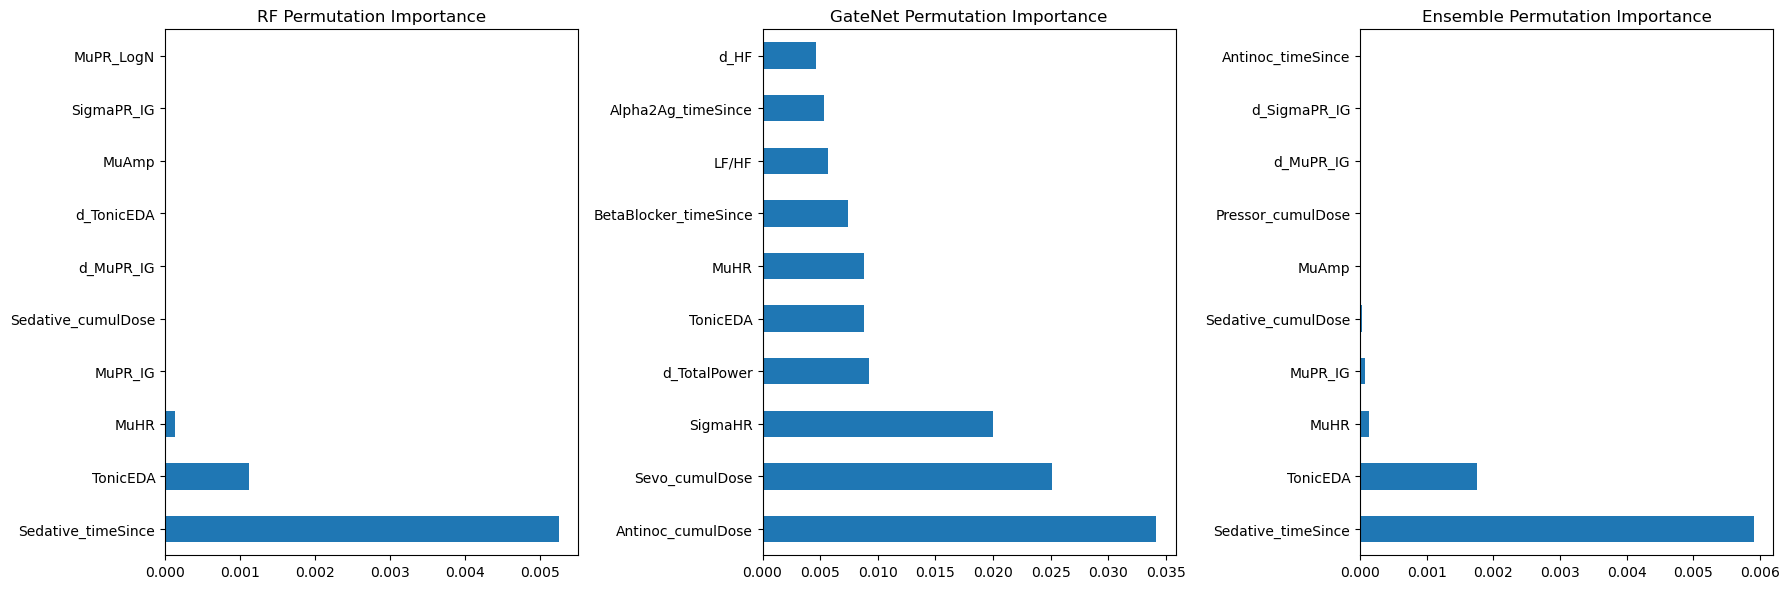

In [12]:
# ── Cell: Permutation Importance ────────────────────
from sklearn.inspection import permutation_importance

# Definitions:
# full_ds, idx_ranges, dfs, device  
# rf: trained RandomForestClassifier for one fold  
# gate: trained GateNet for same fold  
# tl: trained TL model for same fold (if you want full ensemble)  
# feat_idx_drug: np.arange(48)  
# sid: int, which surgery to inspect  
# --------------------------------------------------------------

# 1) Define feature name lists directly
phys_ind_order = [
    "MuHR", "SigmaHR", "TotalPower", "HF", "LFnu",
    "HFnu", "LFnu_noVLF", "LF/HF", "TonicEDA",
    "MuAmp", "SigmaAmp", "MuPR_LogN",
    "SigmaPR_LogN", "MuPR_IG", "SigmaPR_IG"
]
# derivatives
deriv_feats = [f"d_{f}" for f in phys_ind_order]
# drug classes known from dataset
drug_classes = [
    "Sedative", "Antinoc", "MuscleRelaxant", "Pressor",
    "BetaBlocker", "Alpha2Ag", "NMDA-Ant", "Hydralazine", "Sevo"
]
# timeSince and cumulDose for each drug
drug_feats = []
for cls in drug_classes:
    drug_feats += [f"{cls}_timeSince", f"{cls}_cumulDose"]

# full 48-feature list
feature_names = phys_ind_order + deriv_feats + drug_feats

# 2) Build eval set for chosen surgery (post 10‐min adaptation)
idxs     = idx_ranges(sid)
wins     = 10 * 12
eval_idx = idxs[wins:]
X_ev = np.vstack([full_ds[i][0].numpy() for i in eval_idx])[:, feat_idx_drug]
y_ev = np.array([full_ds[i][1].item()   for i in eval_idx])

# 3) RF permutation importance
perm_rf = permutation_importance(
    rf, X_ev, y_ev,
    scoring    = "roc_auc",
    n_repeats  = 10,
    random_state=0,
    n_jobs     = -1
)
rf_imp = pd.Series(perm_rf.importances_mean, index=feature_names).sort_values(ascending=False)

# 4) GateNet permutation importance
def gate_predict(X):
    with torch.no_grad():
        t = torch.from_numpy(X.astype(np.float32)).to(device)
        return gate(t).cpu().numpy()

base_gate_auc = roc_auc_score(y_ev, gate_predict(X_ev))
gate_importances = []
for i, name in enumerate(feature_names):
    X_perm = X_ev.copy()
    np.random.shuffle(X_perm[:, i])
    perm_auc = roc_auc_score(y_ev, gate_predict(X_perm))
    gate_importances.append(base_gate_auc - perm_auc)
gate_imp = pd.Series(gate_importances, index=feature_names).sort_values(ascending=False)

# 5) Optional: Ensemble permutation importance
def ensemble_predict(X):
    p_rf = rf.predict_proba(X)[:,1]
    # TL predictions
    p_tl = []
    dl_ev = DataLoader(Subset(full_ds, eval_idx), batch_size=256, shuffle=False)
    with torch.no_grad():
        for xb, yb in dl_ev:
            xb = xb.to(device)
            p_batch, _ = infer(tl, [(xb, yb)])
            p_tl.append(p_batch)
    p_tl = np.concatenate(p_tl)
    # gate weights
    α = gate_predict(X)
    return α * p_rf + (1-α) * p_tl

base_ens_auc = roc_auc_score(y_ev, ensemble_predict(X_ev))
ens_importances = []
for i, name in enumerate(feature_names):
    X_perm = X_ev.copy()
    np.random.shuffle(X_perm[:, i])
    ens_auc = roc_auc_score(y_ev, ensemble_predict(X_perm))
    ens_importances.append(base_ens_auc - ens_auc)
ens_imp = pd.Series(ens_importances, index=feature_names).sort_values(ascending=False)

# 6) Present top features for each component
print("Top 10 RF features (ΔAUROC drop):")
print(rf_imp.head(10))

print("\nTop 10 GateNet features (ΔAUROC drop):")
print(gate_imp.head(10))

print("\nTop 10 Ensemble features (ΔAUROC drop):")
print(ens_imp.head(10))

# Optionally, plot bar charts:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(18,6))
rf_imp.head(10).plot.barh(ax=axs[0], title="RF Permutation Importance")
gate_imp.head(10).plot.barh(ax=axs[1], title="GateNet Permutation Importance")
ens_imp.head(10).plot.barh(ax=axs[2], title="Ensemble Permutation Importance")
plt.tight_layout()
plt.show()


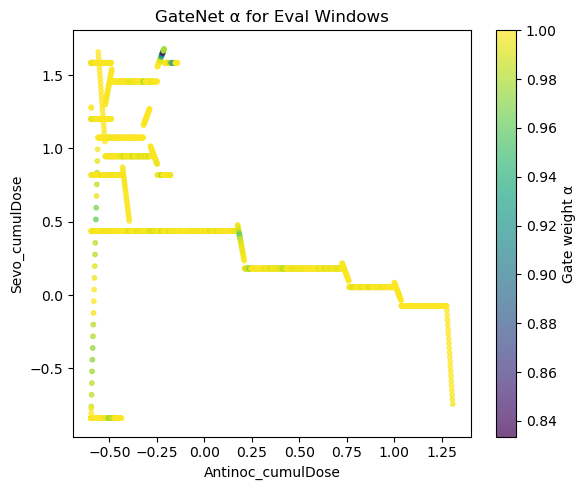

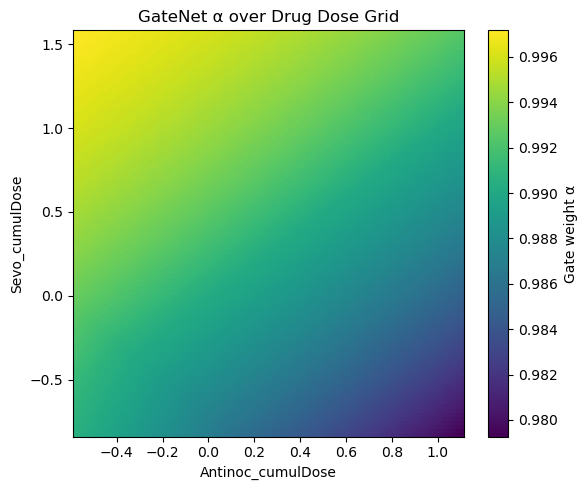

In [13]:


# Definitions:
# gate: your trained GateNet for the chosen fold  
# X_ev: numpy array (N_eval, 48) of eval features  
# feature_names: list of 48 feature names  
# feat_idx_drug: array of feature indices used (48)  
# --------------------------------------------------------------

# 1) Identify indices for the two most important drug features
idx_anti = feature_names.index("Antinoc_cumulDose")
idx_sevo = feature_names.index("Sevo_cumulDose")

# Helper to compute gate weight (α) for any X
def gate_predict(X):
    with torch.no_grad():
        t = torch.from_numpy(X.astype(np.float32)).to(device)
        return gate(t).cpu().numpy()

# 2) Scatter plot of actual eval windows colored by α
alpha_ev = gate_predict(X_ev)

plt.figure(figsize=(6,5))
sc = plt.scatter(
    X_ev[:, idx_anti], 
    X_ev[:, idx_sevo], 
    c=alpha_ev, 
    cmap="viridis", 
    s=10, 
    alpha=0.7
)
plt.colorbar(sc, label="Gate weight α")
plt.xlabel("Antinoc_cumulDose")
plt.ylabel("Sevo_cumulDose")
plt.title("GateNet α for Eval Windows")
plt.tight_layout()
plt.show()

# 3) 2D heatmap on a grid of drug doses
n_grid = 100
anti_vals = np.linspace(
    np.percentile(X_ev[:, idx_anti], 5),
    np.percentile(X_ev[:, idx_anti], 95),
    n_grid
)
sevo_vals = np.linspace(
    np.percentile(X_ev[:, idx_sevo], 5),
    np.percentile(X_ev[:, idx_sevo], 95),
    n_grid
)

# Baseline feature vector: median across eval set
base_feat = np.median(X_ev, axis=0)

grid_alpha = np.zeros((n_grid, n_grid))
for i, a in enumerate(anti_vals):
    for j, s in enumerate(sevo_vals):
        x = base_feat.copy()
        x[idx_anti] = a
        x[idx_sevo] = s
        grid_alpha[j, i] = gate_predict(x.reshape(1, -1))[0]

plt.figure(figsize=(6,5))
plt.imshow(
    grid_alpha,
    origin="lower",
    extent=(anti_vals[0], anti_vals[-1], sevo_vals[0], sevo_vals[-1]),
    aspect="auto",
    cmap="viridis"
)
plt.colorbar(label="Gate weight α")
plt.xlabel("Antinoc_cumulDose")
plt.ylabel("Sevo_cumulDose")
plt.title("GateNet α over Drug Dose Grid")
plt.tight_layout()
plt.show()
